In [1]:
import pandas as pd
from datetime import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load csv File
df = {'id': [], 'time': [], 'gl': []}

with open('raw_data/iglu_example_data_5_subject.csv') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        # check for NAs
        if 'NA' in row:
            continue
        
        if row[0] == 'id': # exclude row with column names
            continue
            
        df['id'].append(row[0]) # add current row's id
        dt = datetime.strptime(row[1], '%Y-%m-%d %H:%M:%S') # convert timestamps to datetime format so graphs dont break
        df['time'].append(dt)
        df['gl'].append(float(row[2])) # Convert glucose levels to floats

df = pd.DataFrame(df)
df

id                time     gl
0      Subject 1 2015-06-06 16:50:27  153.0
1      Subject 1 2015-06-06 17:05:27  137.0
2      Subject 1 2015-06-06 17:10:27  128.0
3      Subject 1 2015-06-06 17:15:28  121.0
4      Subject 1 2015-06-06 17:25:27  120.0
...          ...                 ...    ...
13861  Subject 5 2015-03-11 07:44:28  230.0
13862  Subject 5 2015-03-11 07:49:28  238.0
13863  Subject 5 2015-03-11 07:54:28  244.0
13864  Subject 5 2015-03-11 07:59:28  245.0
13865  Subject 5 2015-03-11 08:04:28  238.0

[13866 rows x 3 columns]

In [29]:
##### draft code for interpolation function

# get unique ids and sort 
ids = list(set(df['id'].tolist()))
ids.sort()

subnum = 0 # define subject counter
for i in ids:
    subnum += 1 # start loop by incrementing subject

    # subset data to this subject and add lag column in minutes
    data = df.loc[df['id'] == i].copy()
    data['lag'] = data['time'].diff().astype('timedelta64[m]')

    # find gap indices for this subject where gaps are lag > 45 minutes
    idx = np.where(data['lag'] > 45)[0].tolist() # index is the location following gap (i.e. start next segment)
    # add zero and ending index for taking the difference
    idx = [0] + idx + [len(data['lag'])]

    for j in range(1, len(idx)):
        ## if segment is less than an hour of data, then skip interpolation (data will not be appended)
        if idx[j] - idx[j-1] < 12: continue

        ## otherwise proceed with interpolation
        # slice and copy the data corresponding to this segment
        segment = data.iloc[idx[j-1]:idx[j]].copy()
        # create index as time for resampling?
        segment.index = segment['time']
        # resample to secondly, interpolate, then resample to 5 minutes to get grid points
        segment = segment.resample('s').mean().interpolate(method = 'linear') \
            .resample('5T').interpolate(method = 'linear')
        # add segment counter, id, and time because time gets dropped above
        segment['segment'] = j
        segment['id'] = i
        segment['time'] = segment.index

        # if first segment, then df1 is just this segment; else df1 needs to append the current segment
        if j == 1:
            df1 = segment.copy()
        else:
            df1 = df1.append(segment)
    # if first subject, then copy; else append
    if subnum == 1:
        dfsubject = df1.copy()
    else:
        dfsubject = dfsubject.append(df1)

# reorder golumns
dfsubject = dfsubject[['id', 'segment', 'time', 'gl', 'lag']]    

In [30]:
dfsubject

id  segment                time          gl  lag
time                                                                        
2015-06-06 16:50:00  Subject 1        1 2015-06-06 16:50:00         NaN  NaN
2015-06-06 16:55:00  Subject 1        1 2015-06-06 16:55:00  148.146667  NaN
2015-06-06 17:00:00  Subject 1        1 2015-06-06 17:00:00  142.813333  NaN
2015-06-06 17:05:00  Subject 1        1 2015-06-06 17:05:00  137.480000  NaN
2015-06-06 17:10:00  Subject 1        1 2015-06-06 17:10:00  128.810000  5.9
...                        ...      ...                 ...         ...  ...
2015-03-11 07:40:00  Subject 5        6 2015-03-11 07:40:00  224.640000  5.0
2015-03-11 07:45:00  Subject 5        6 2015-03-11 07:45:00  230.853333  5.0
2015-03-11 07:50:00  Subject 5        6 2015-03-11 07:50:00  238.640000  5.0
2015-03-11 07:55:00  Subject 5        6 2015-03-11 07:55:00  244.106667  5.0
2015-03-11 08:00:00  Subject 5        6 2015-03-11 08:00:00  244.253333  5.0

[14237 rows x 5 columns]

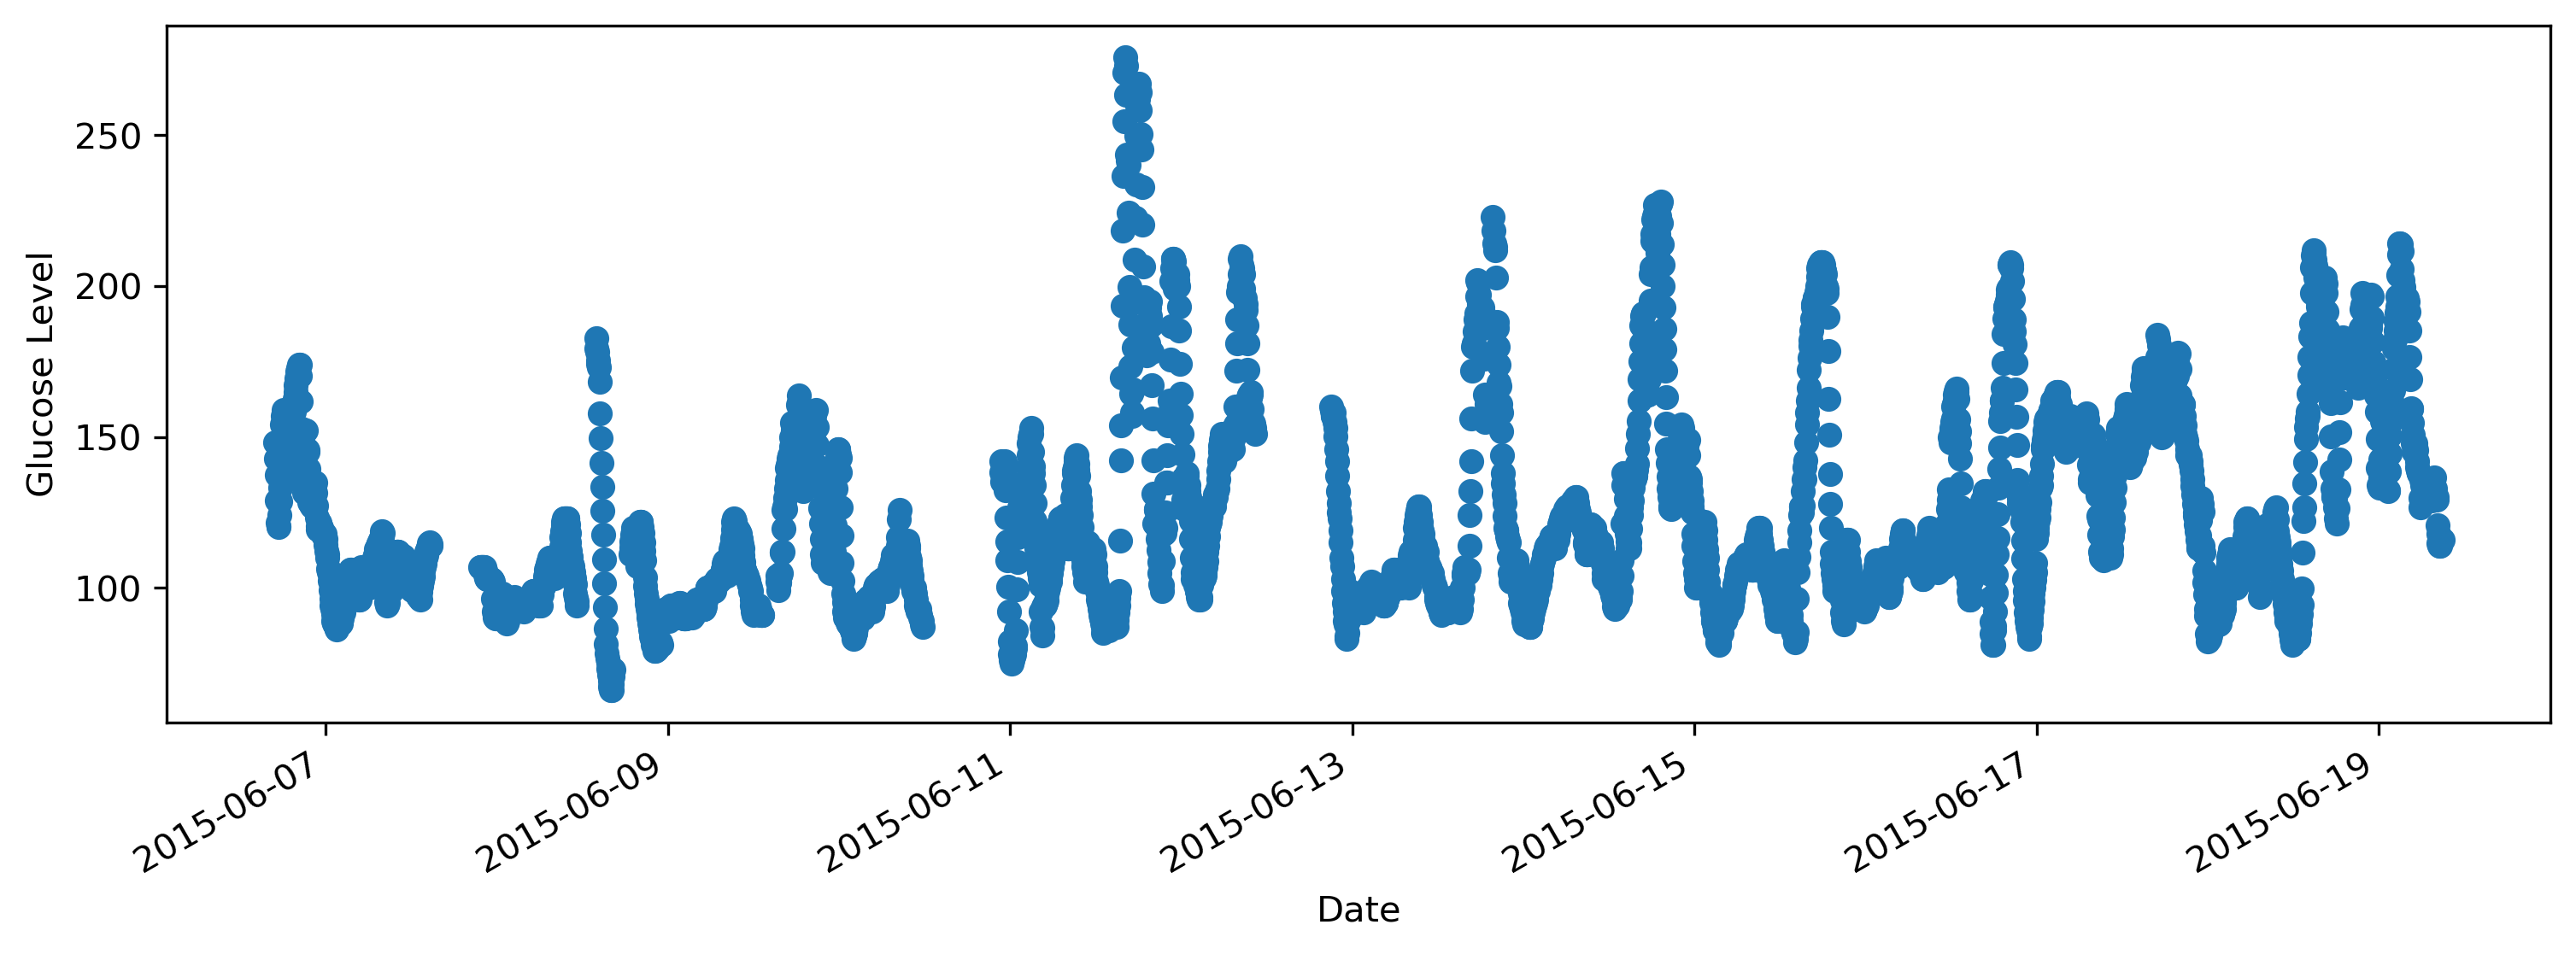

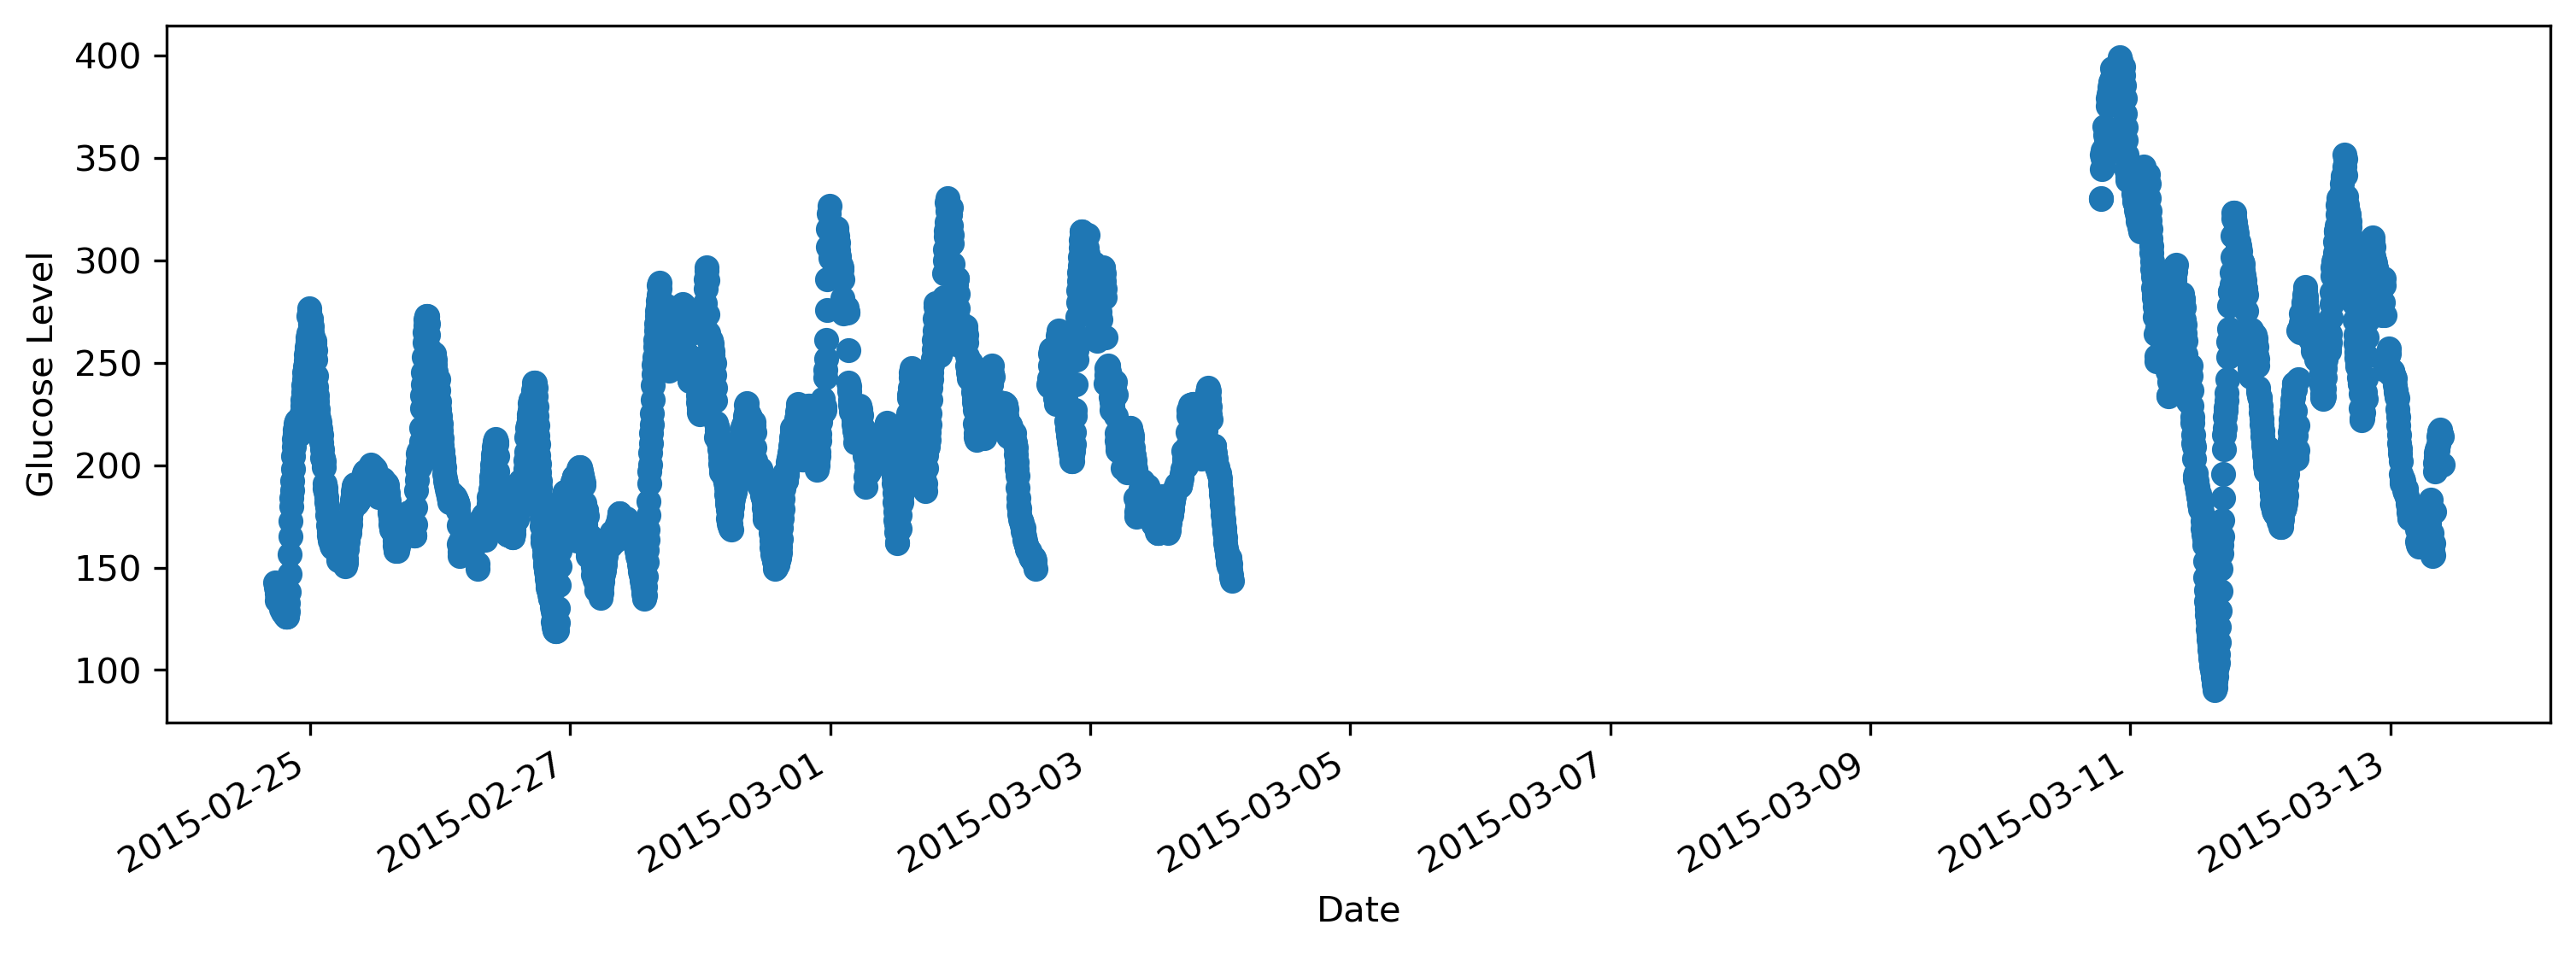

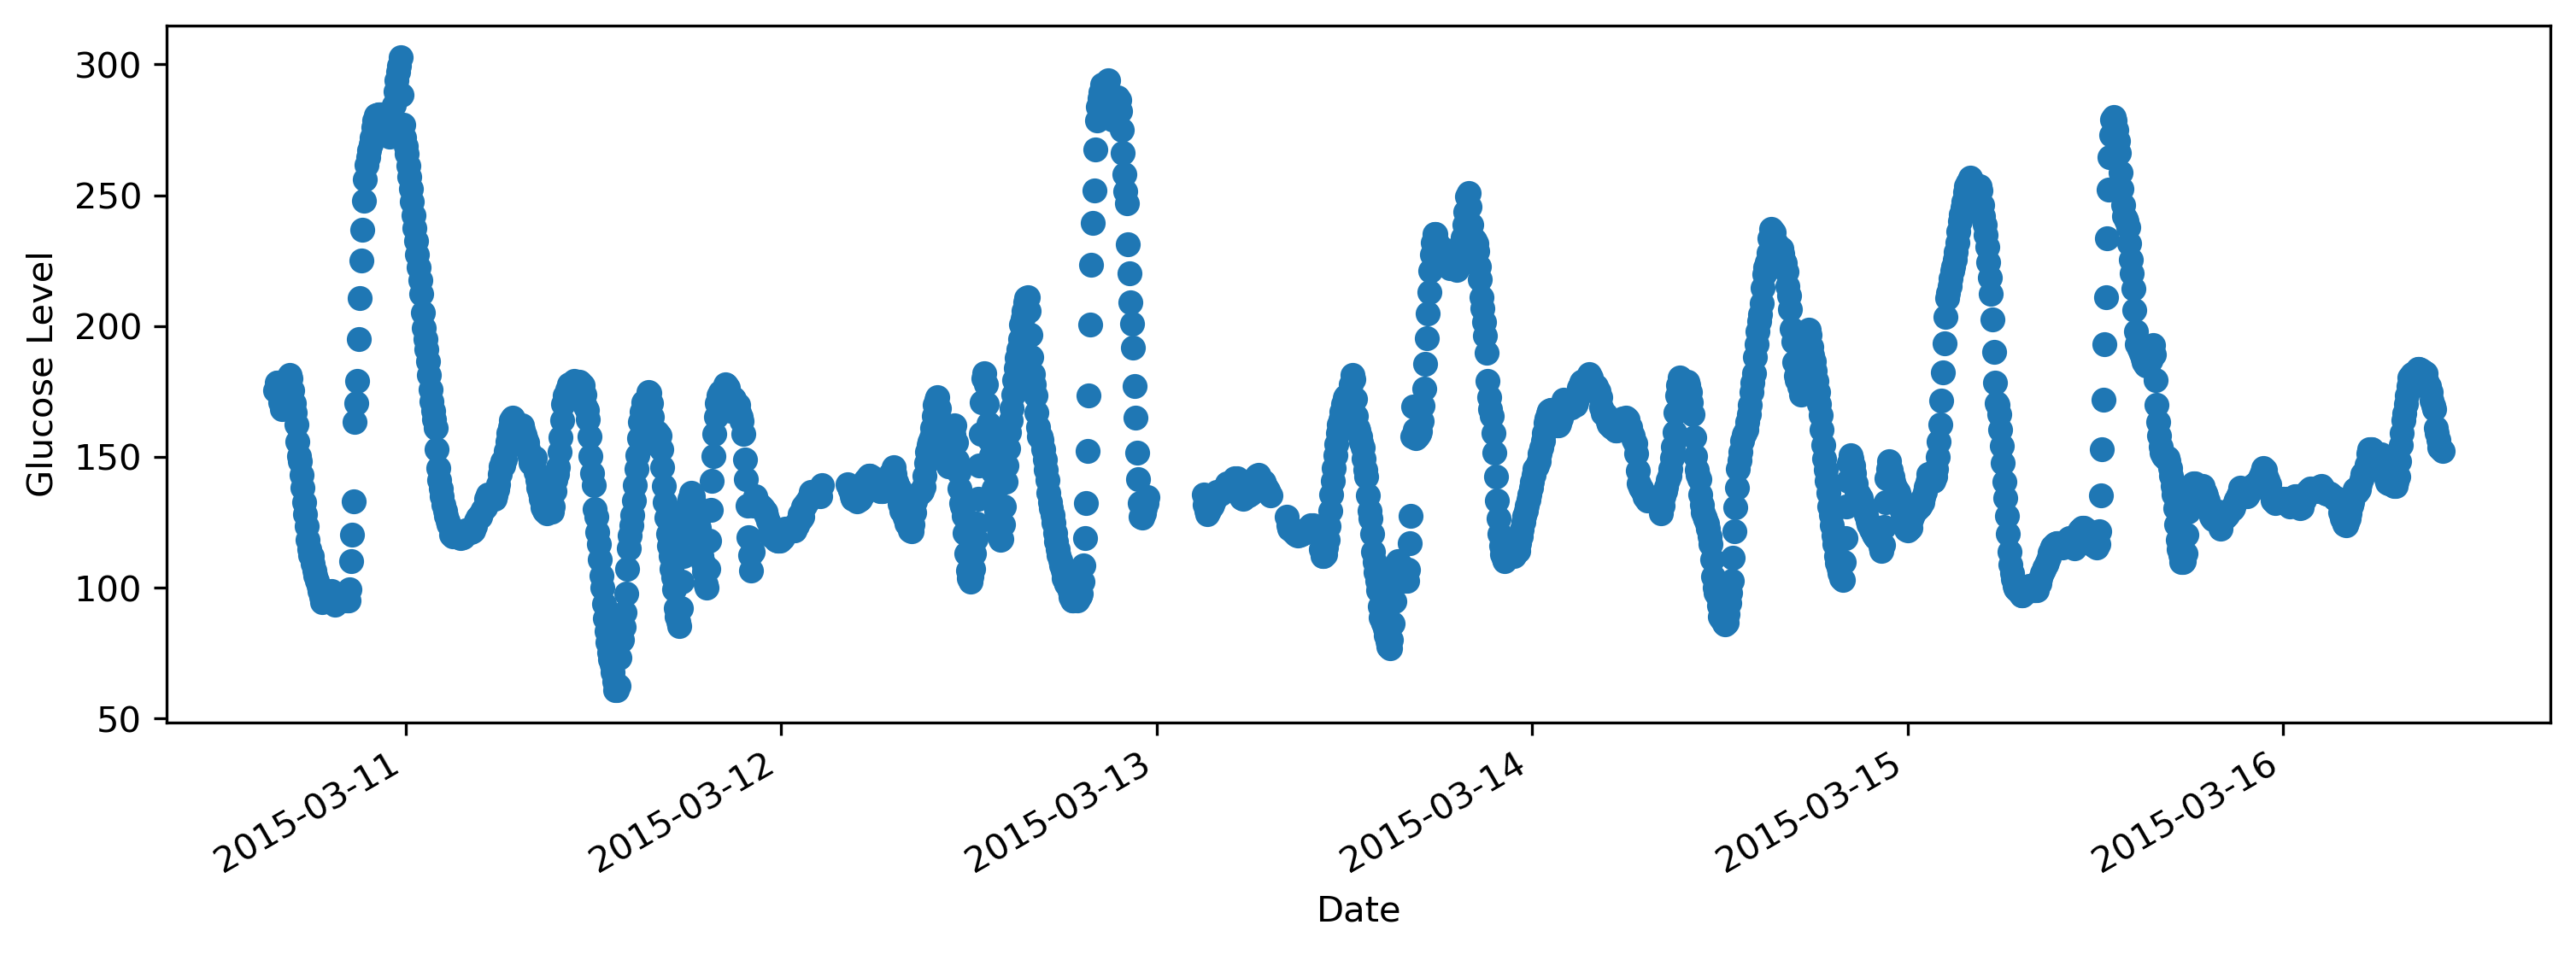

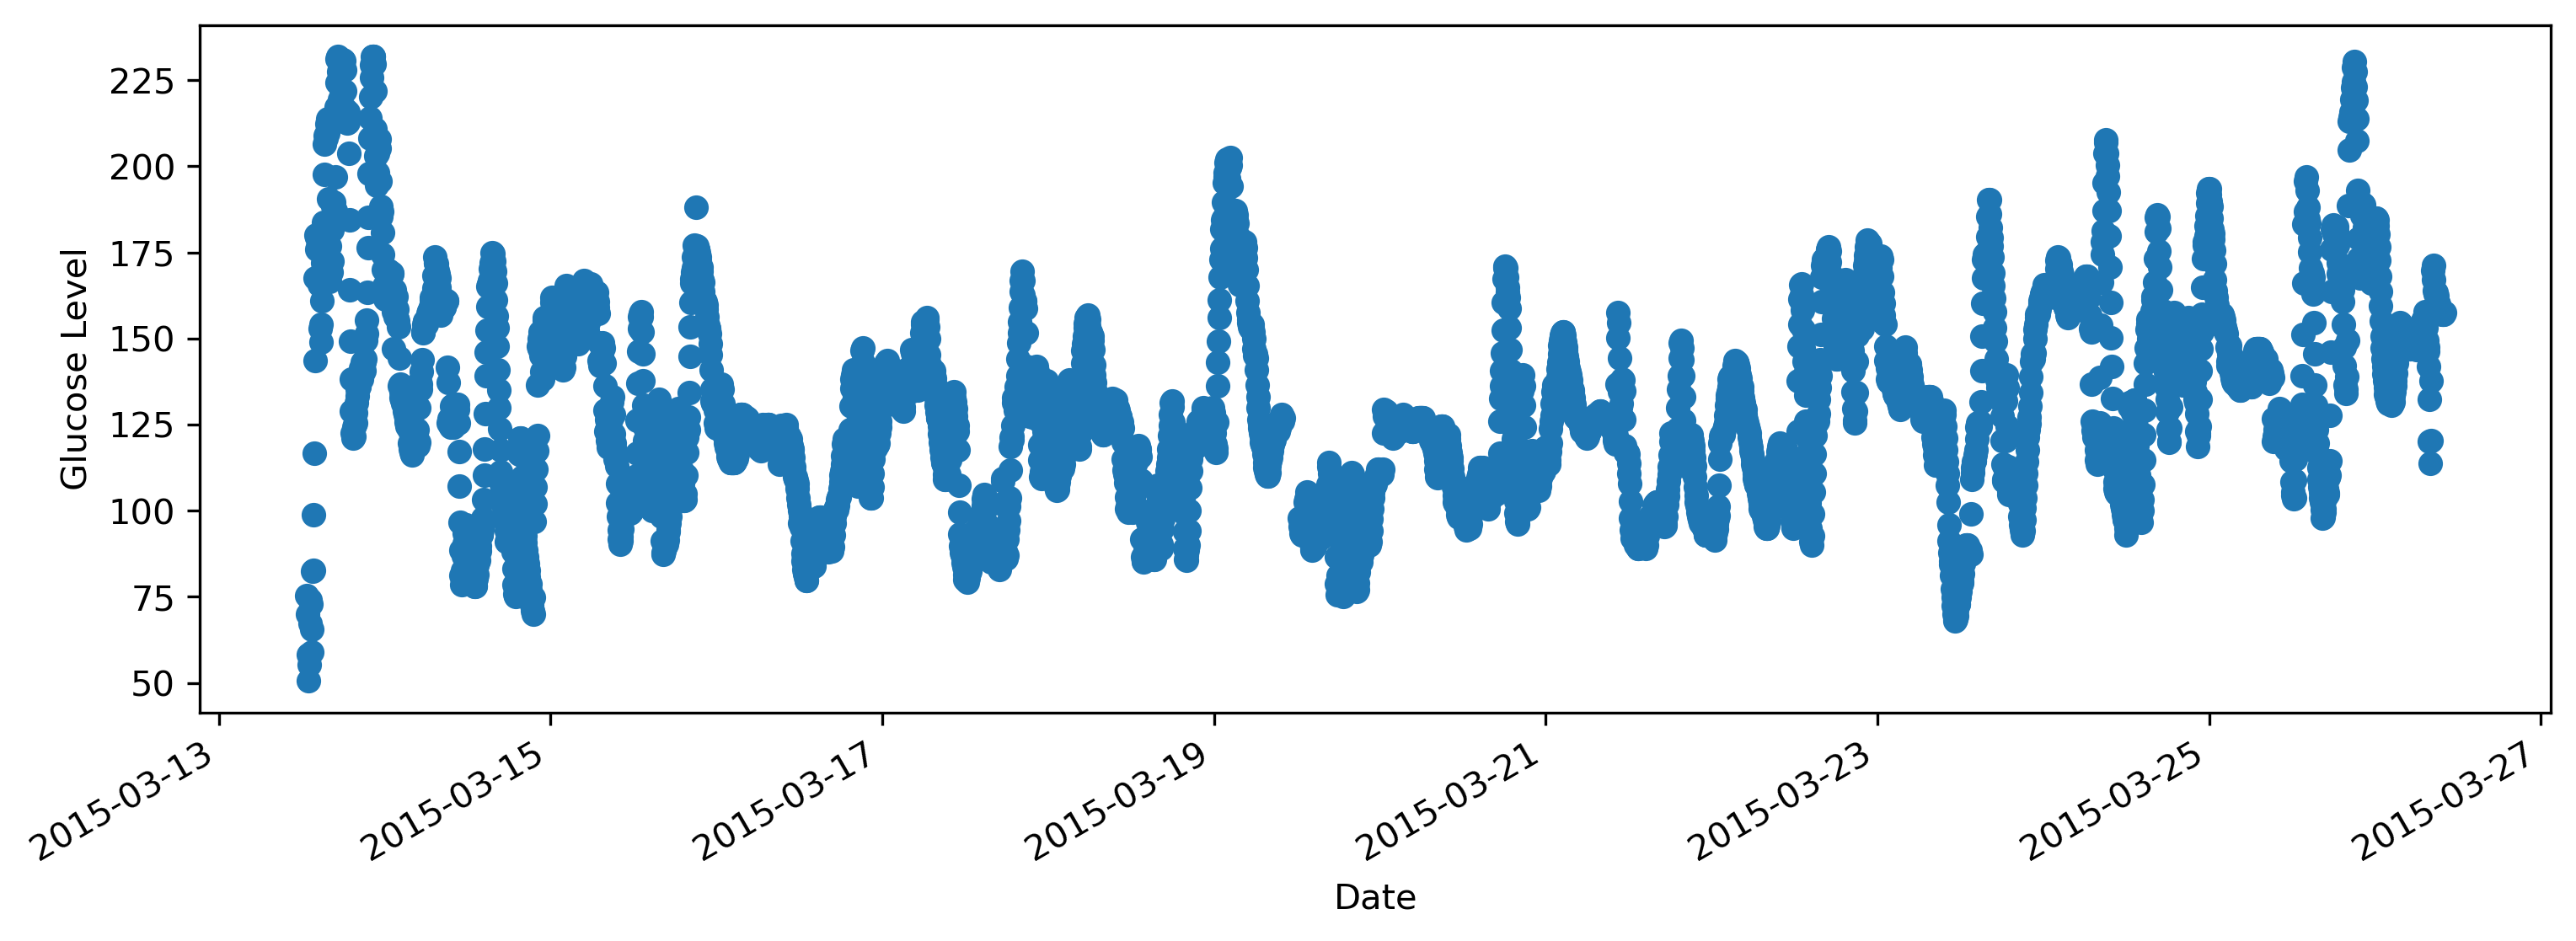

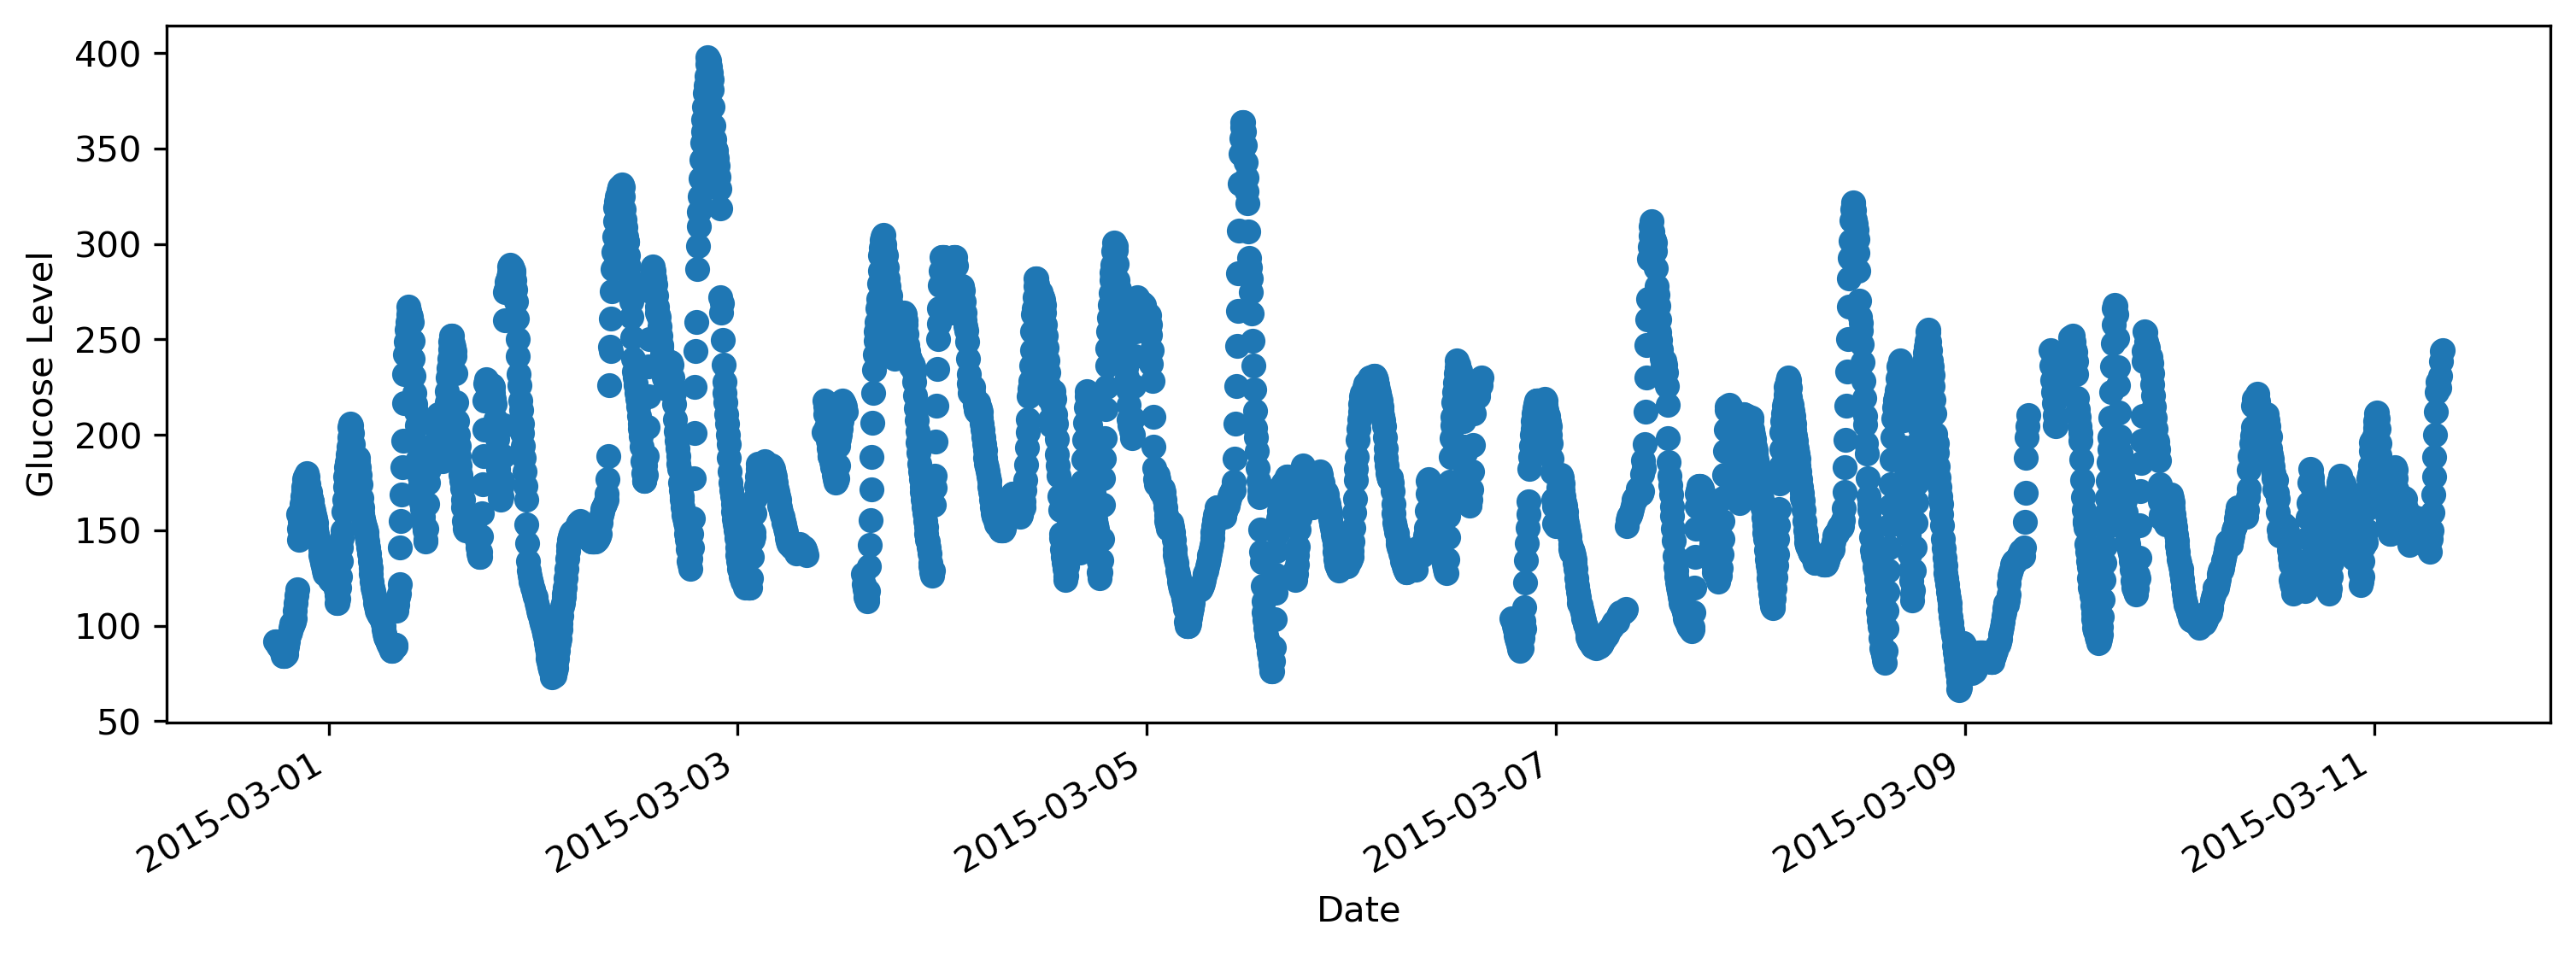

In [32]:
## plot interpolated data by subject
for i in ids:
    x = dfsubject.loc[dfsubject['id'] == i].time
    y = dfsubject.loc[dfsubject['id'] == i].gl

    fig, ax = plt.subplots(figsize = (12,4), dpi = 300)
    ax.plot_date(x, y)
    plt.xlabel("Date")    
    plt.ylabel("Glucose Level")
        
    fig.autofmt_xdate() # slant x-axis
    plt.show()

Work zone below

In [ ]:
segment = data.iloc[tmp[j-1]:tmp[j]].copy()
segment.index = segment['time']
segment = segment.resample('s').mean().interpolate(method = 'linear').resample('5T').interpolate(method = 'linear')
# segment['segment'] = j
segment

In [87]:
small = df[0:200]
small.index = small['time']
small.resample('s').mean().interpolate(method = 'linear').resample('5T').interpolate(method = 'linear')

gl        lag
time                                      
2015-06-06 16:50:00         NaN        NaN
2015-06-06 16:55:00  148.146667        NaN
2015-06-06 17:00:00  142.813333        NaN
2015-06-06 17:05:00  137.480000        NaN
2015-06-06 17:10:00  128.810000   5.900000
...                         ...        ...
2015-06-07 14:25:00  113.948889  14.846667
2015-06-07 14:30:00  114.923333   5.766667
2015-06-07 14:35:00  115.000000   5.000000
2015-06-07 14:40:00  114.538333   7.308333
2015-06-07 14:45:00  114.038333   9.808333

[264 rows x 2 columns]

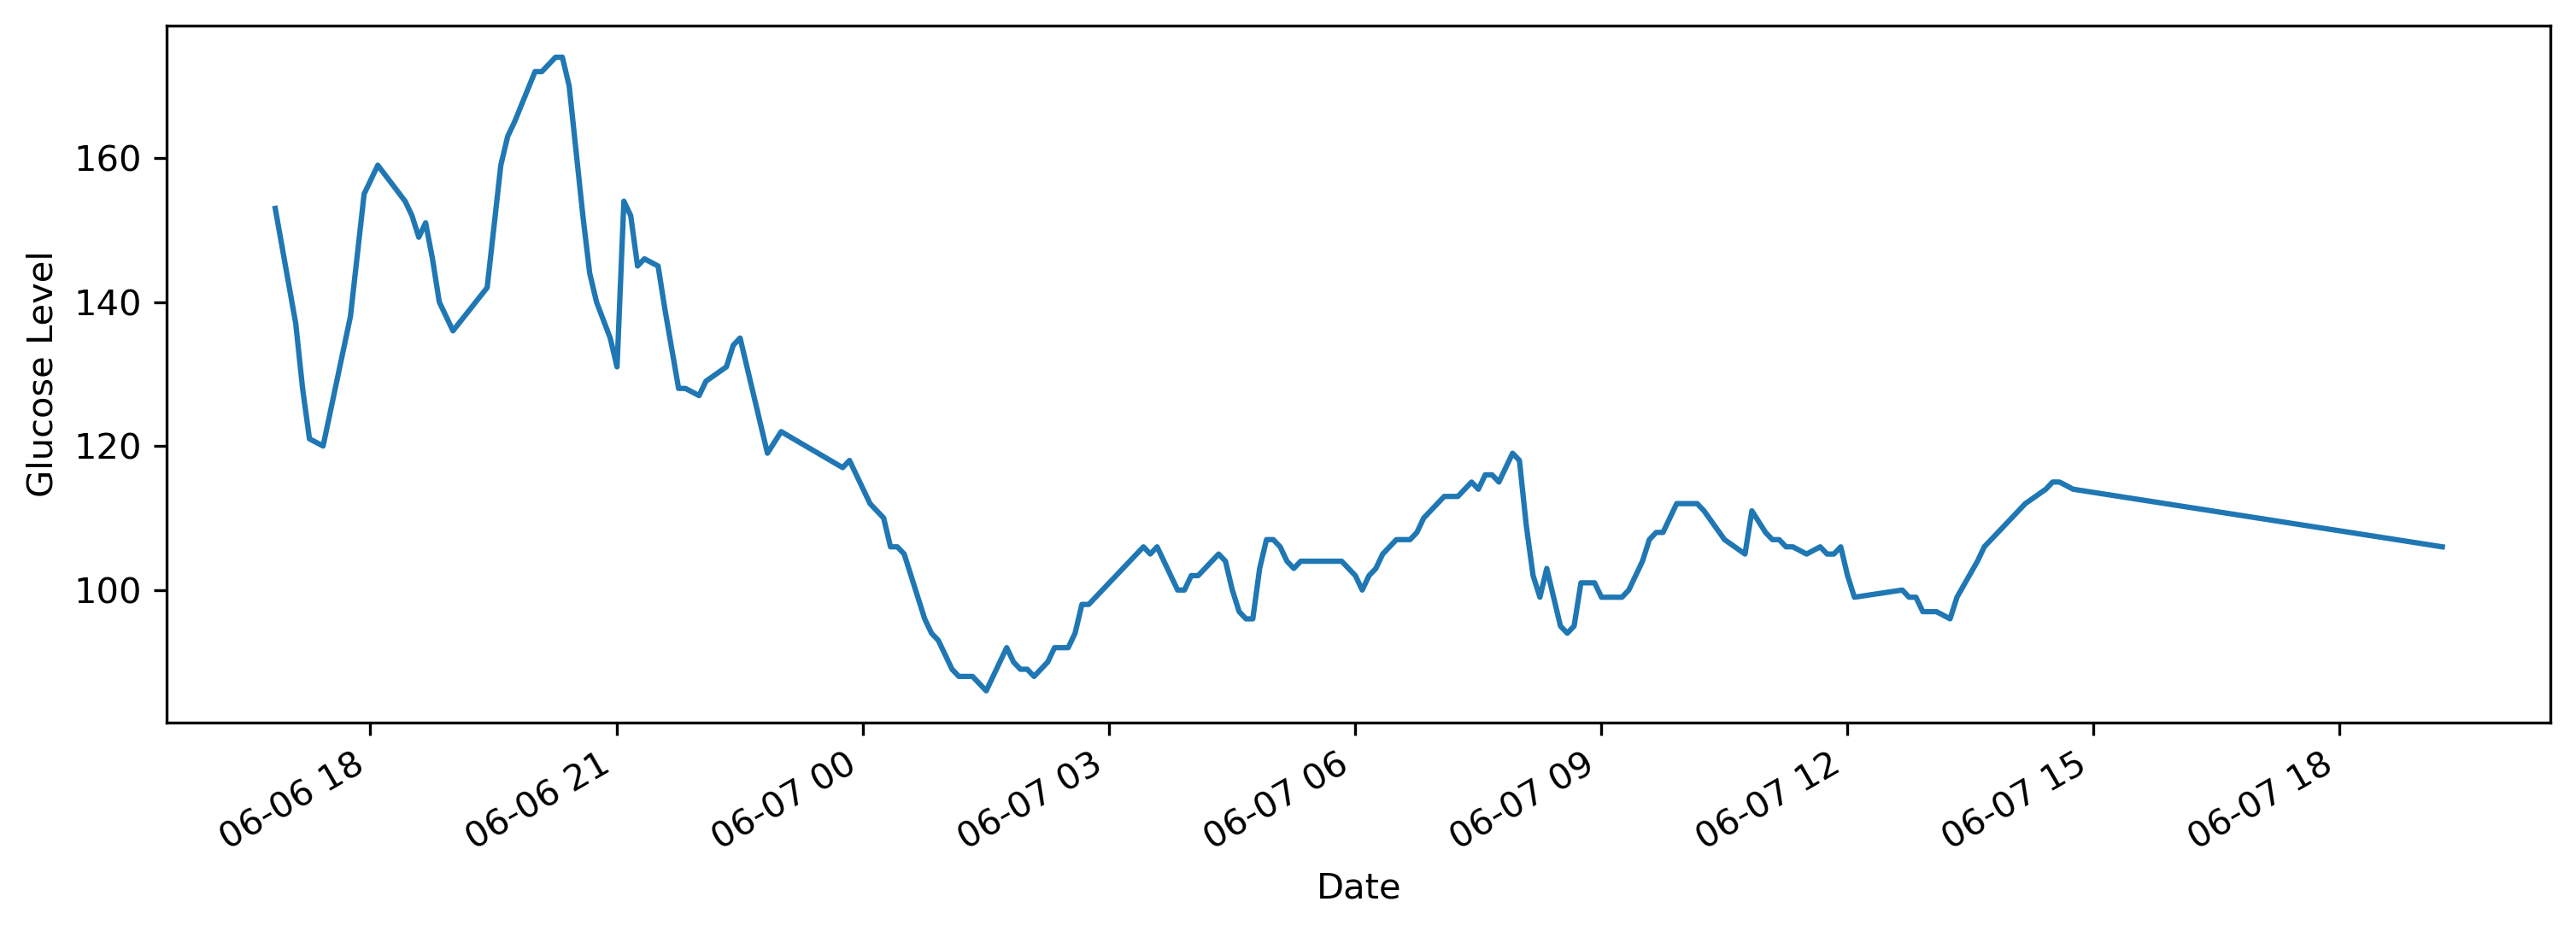

In [16]:
x = df.iloc[0:201].time
y = df.iloc[0:201].gl

fig, ax = plt.subplots(figsize = (12,4), dpi = 300)
ax.plot(x, y)
plt.xlabel("Date")    
plt.ylabel("Glucose Level")
    
fig.autofmt_xdate() # slant x-axis
plt.show()

Copied Nicky's plotting code for Dubosson

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import calendar
import csv

In [11]:
from conf import Conf

In [2]:
# Load csv File
df = {'id': [], 'time': [], 'gl': []}

with open('raw_data/iglu_example_data_5_subject.csv') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        # check for NAs
        if 'NA' in row:
            continue
        
        if row[0] == 'id': # exclude row with column names
            continue
            
        df['id'].append(row[0]) # add current row's id
        dt = datetime.strptime(row[1], '%Y-%m-%d %H:%M:%S') # convert timestamps to datetime format so graphs dont break
        df['time'].append(dt)
        df['gl'].append(float(row[2])) # Convert glucose levels to floats

df = pd.DataFrame(df)
df

id                time     gl
0      Subject 1 2015-06-06 16:50:27  153.0
1      Subject 1 2015-06-06 17:05:27  137.0
2      Subject 1 2015-06-06 17:10:27  128.0
3      Subject 1 2015-06-06 17:15:28  121.0
4      Subject 1 2015-06-06 17:25:27  120.0
...          ...                 ...    ...
13861  Subject 5 2015-03-11 07:44:28  230.0
13862  Subject 5 2015-03-11 07:49:28  238.0
13863  Subject 5 2015-03-11 07:54:28  244.0
13864  Subject 5 2015-03-11 07:59:28  245.0
13865  Subject 5 2015-03-11 08:04:28  238.0

[13866 rows x 3 columns]

In [3]:
# sort by time
sorted_df = pd.DataFrame(df.sort_values(by = ["time"])).reset_index()
sorted_df

index         id                time     gl
0       2915  Subject 2 2015-02-24 17:31:29  144.0
1       2916  Subject 2 2015-02-24 17:36:29  142.0
2       2917  Subject 2 2015-02-24 17:41:29  141.0
3       2918  Subject 2 2015-02-24 17:46:29  140.0
4       2919  Subject 2 2015-02-24 17:51:29  136.0
...      ...        ...                 ...    ...
13861   2910  Subject 1 2015-06-19 08:39:36  115.0
13862   2911  Subject 1 2015-06-19 08:44:36  115.0
13863   2912  Subject 1 2015-06-19 08:49:36  116.0
13864   2913  Subject 1 2015-06-19 08:54:36  116.0
13865   2914  Subject 1 2015-06-19 08:59:36  115.0

[13866 rows x 4 columns]

In [4]:
# Grouping data by ID
IDs = []
for ID in df.id:
    if ID not in IDs:
        IDs.append(ID)

# Group Subject Data
subj_data = dict()
for ID in IDs:
    subj_data[ID] = df.loc[df['id'] == ID].reset_index()

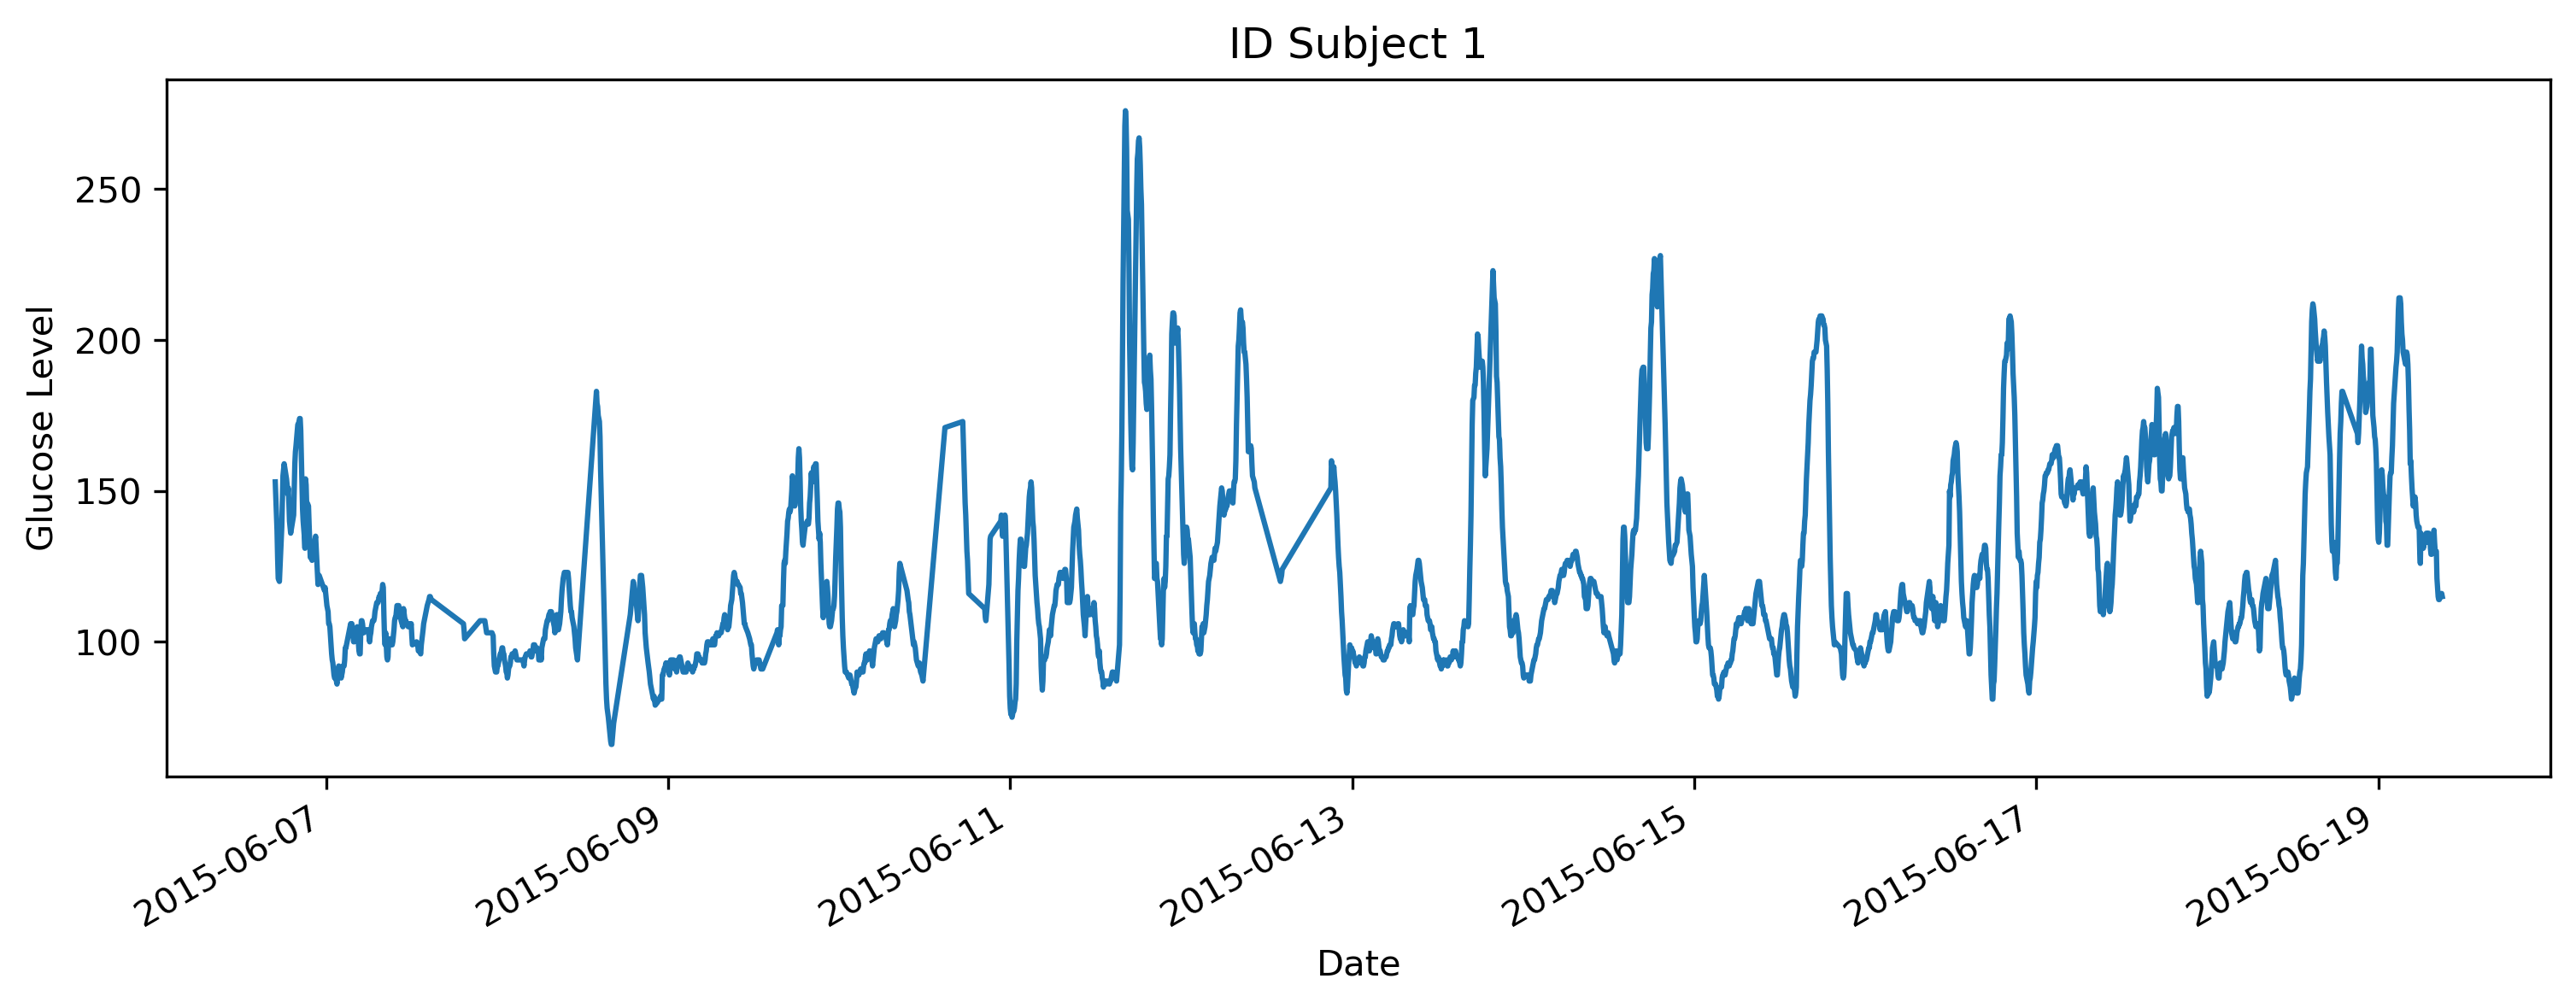

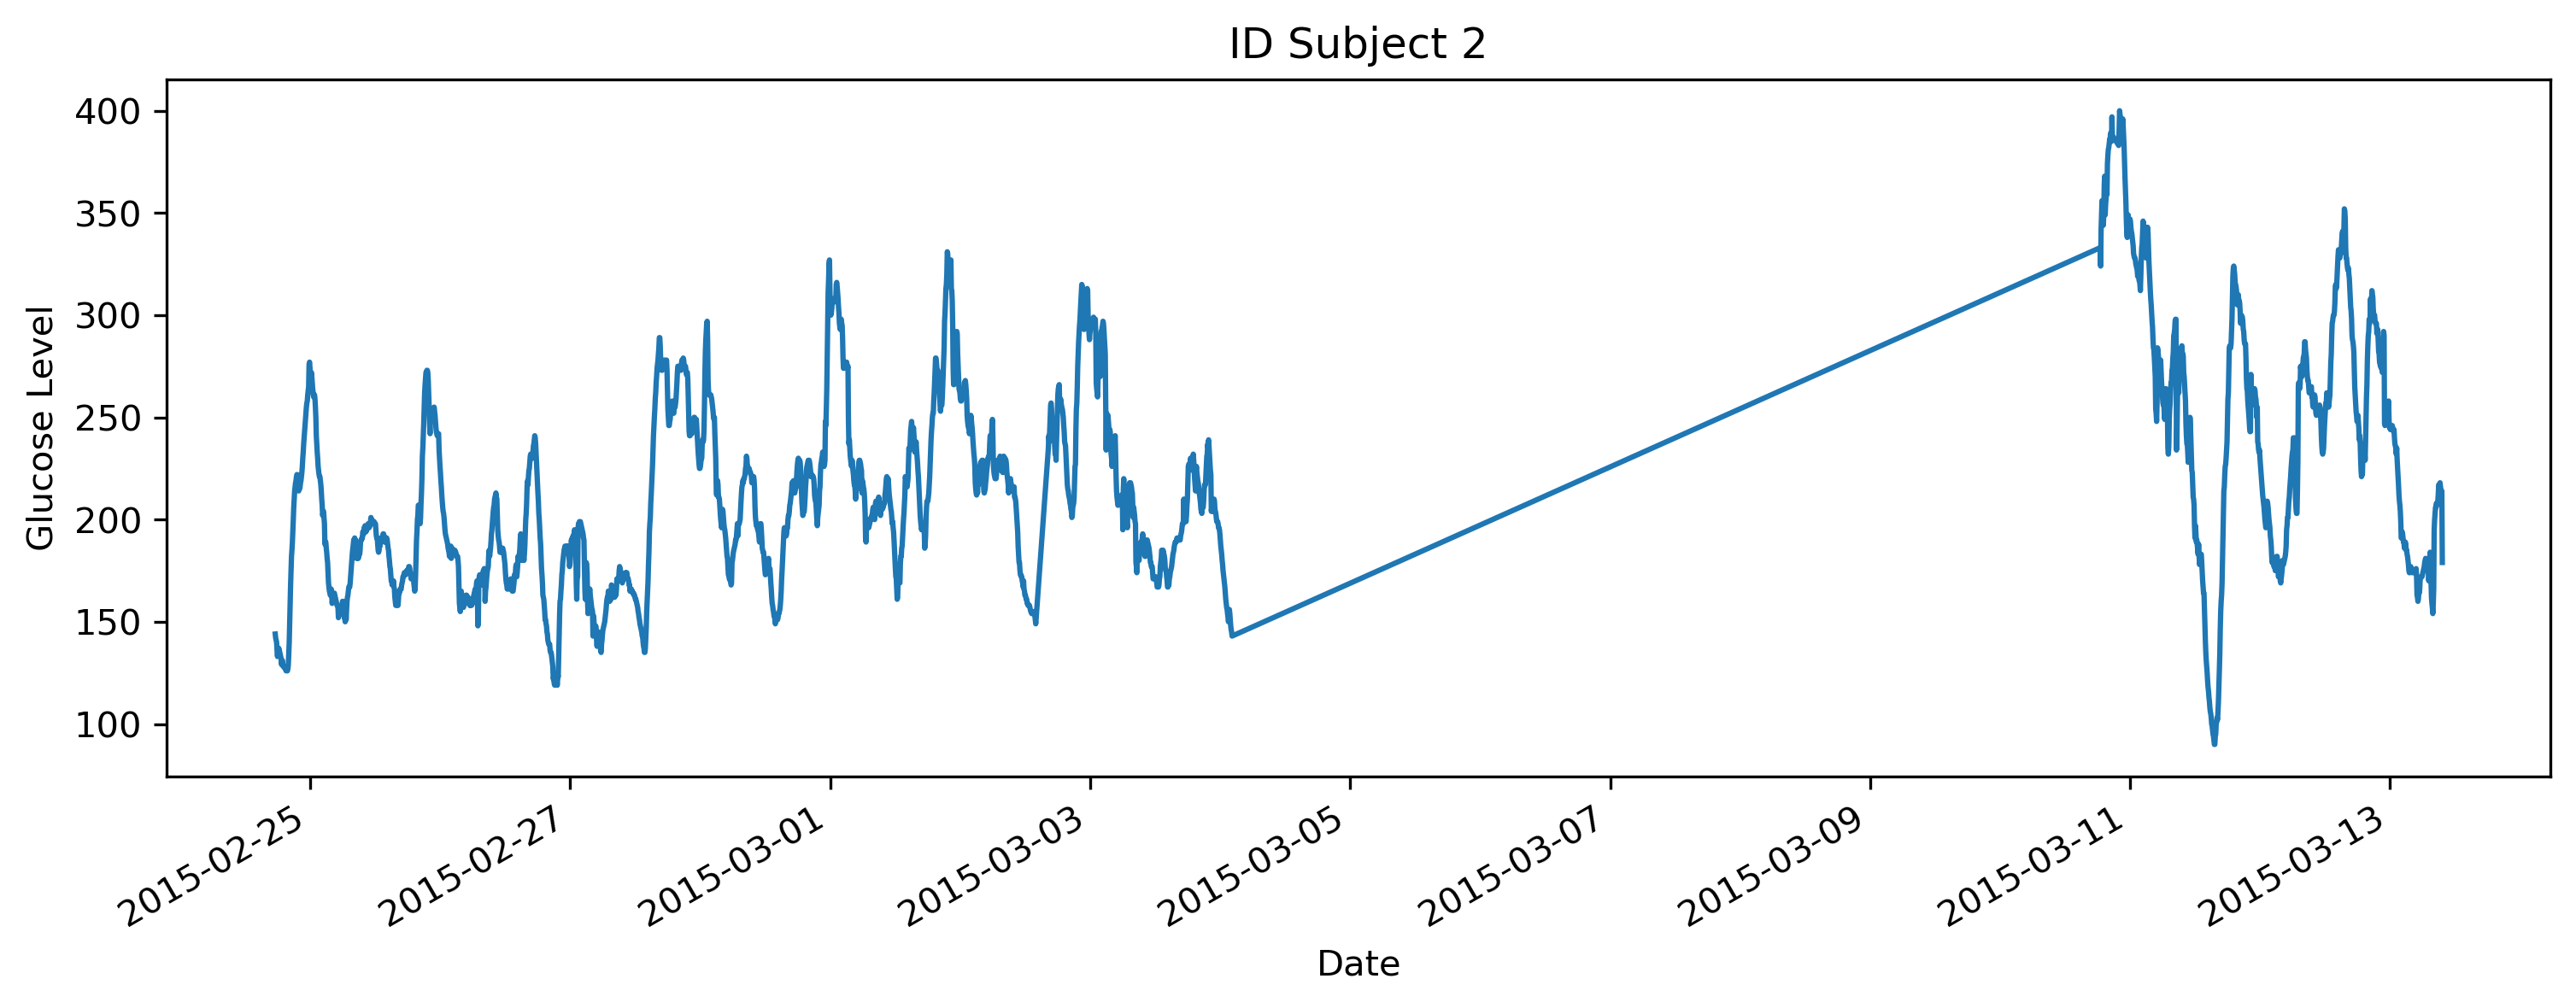

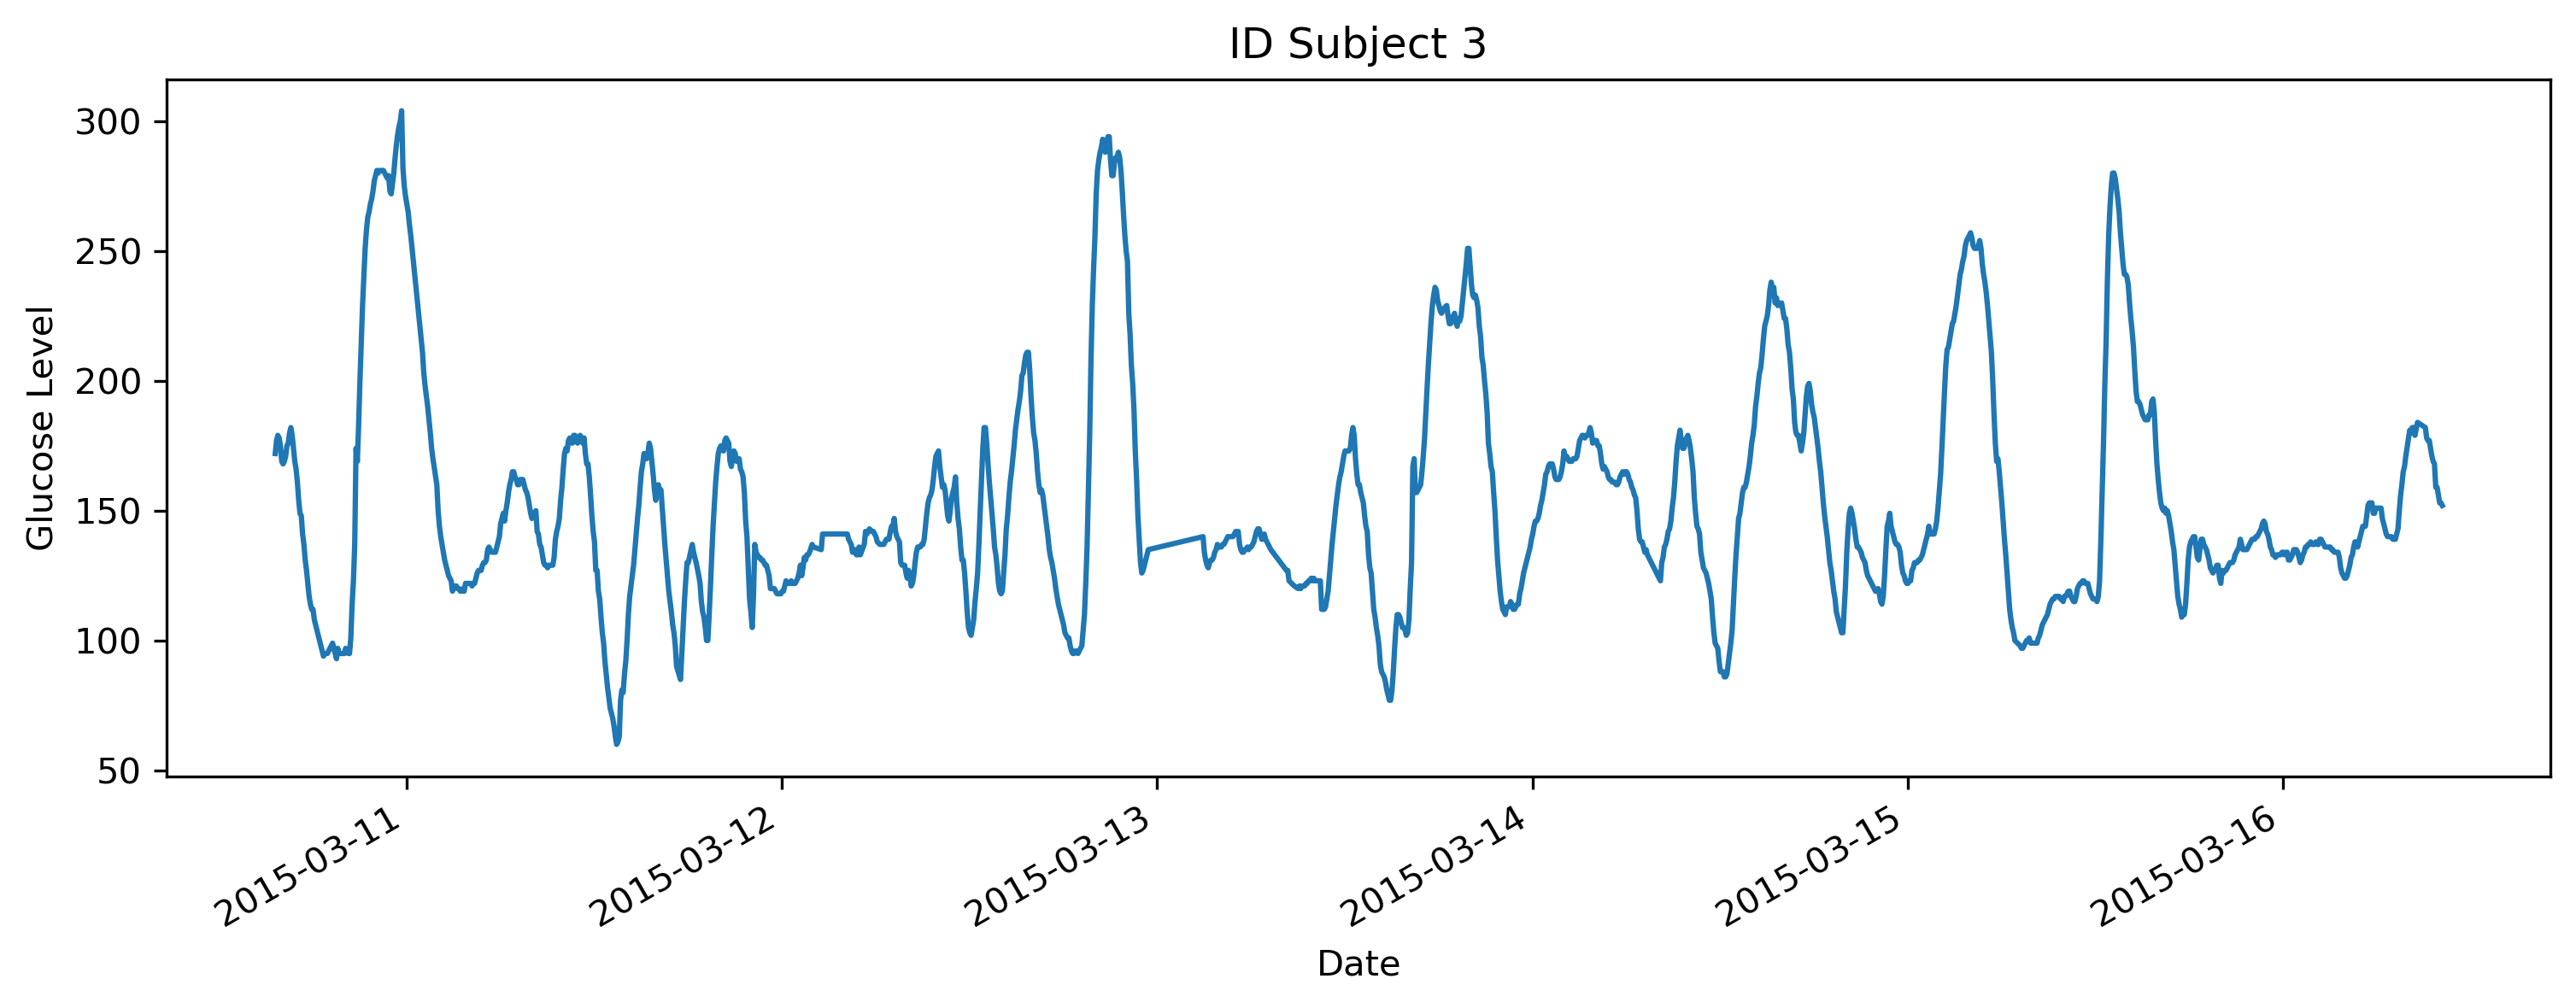

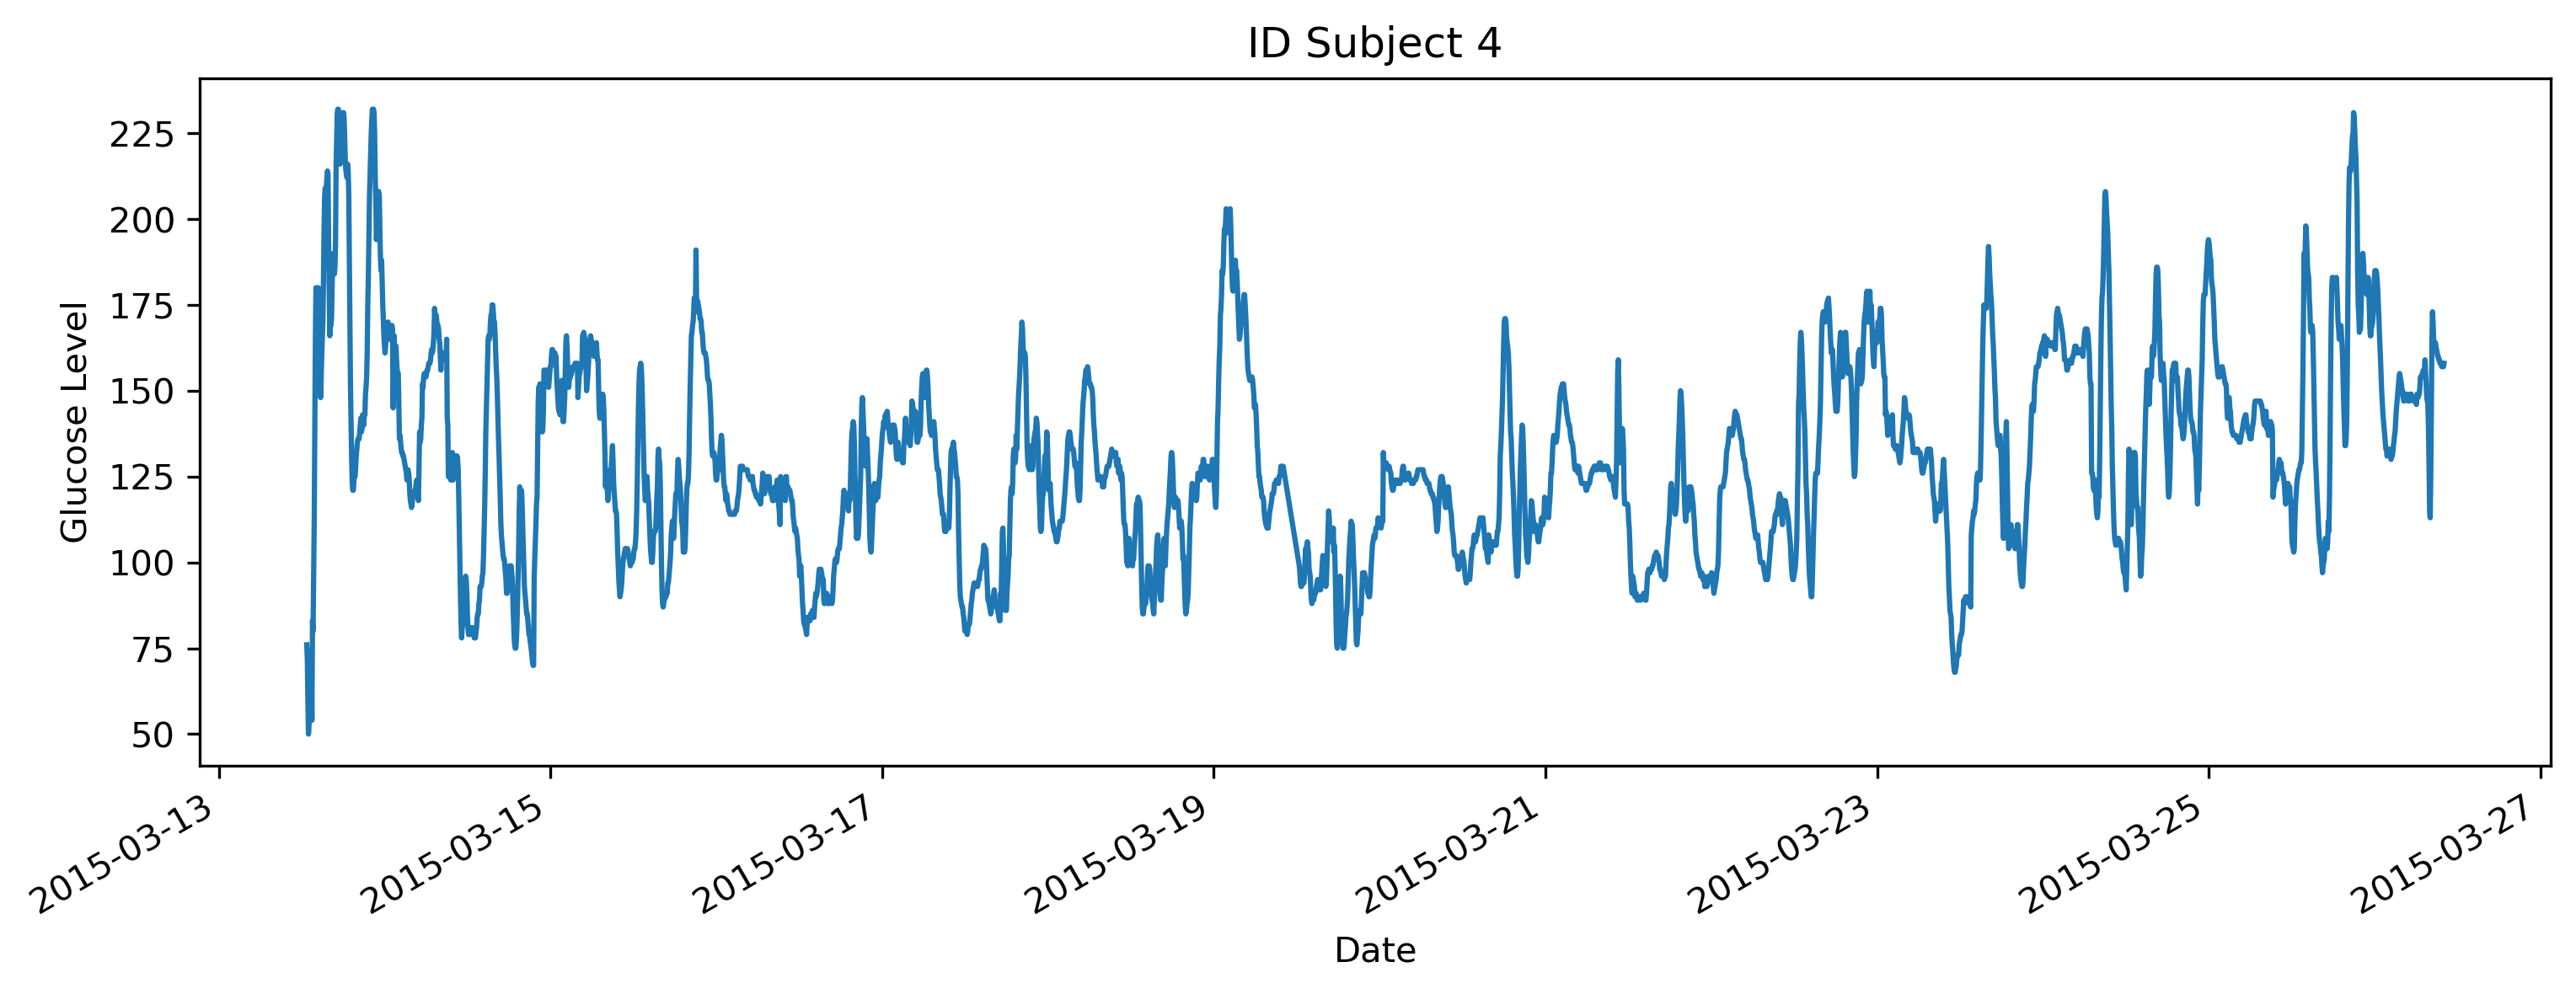

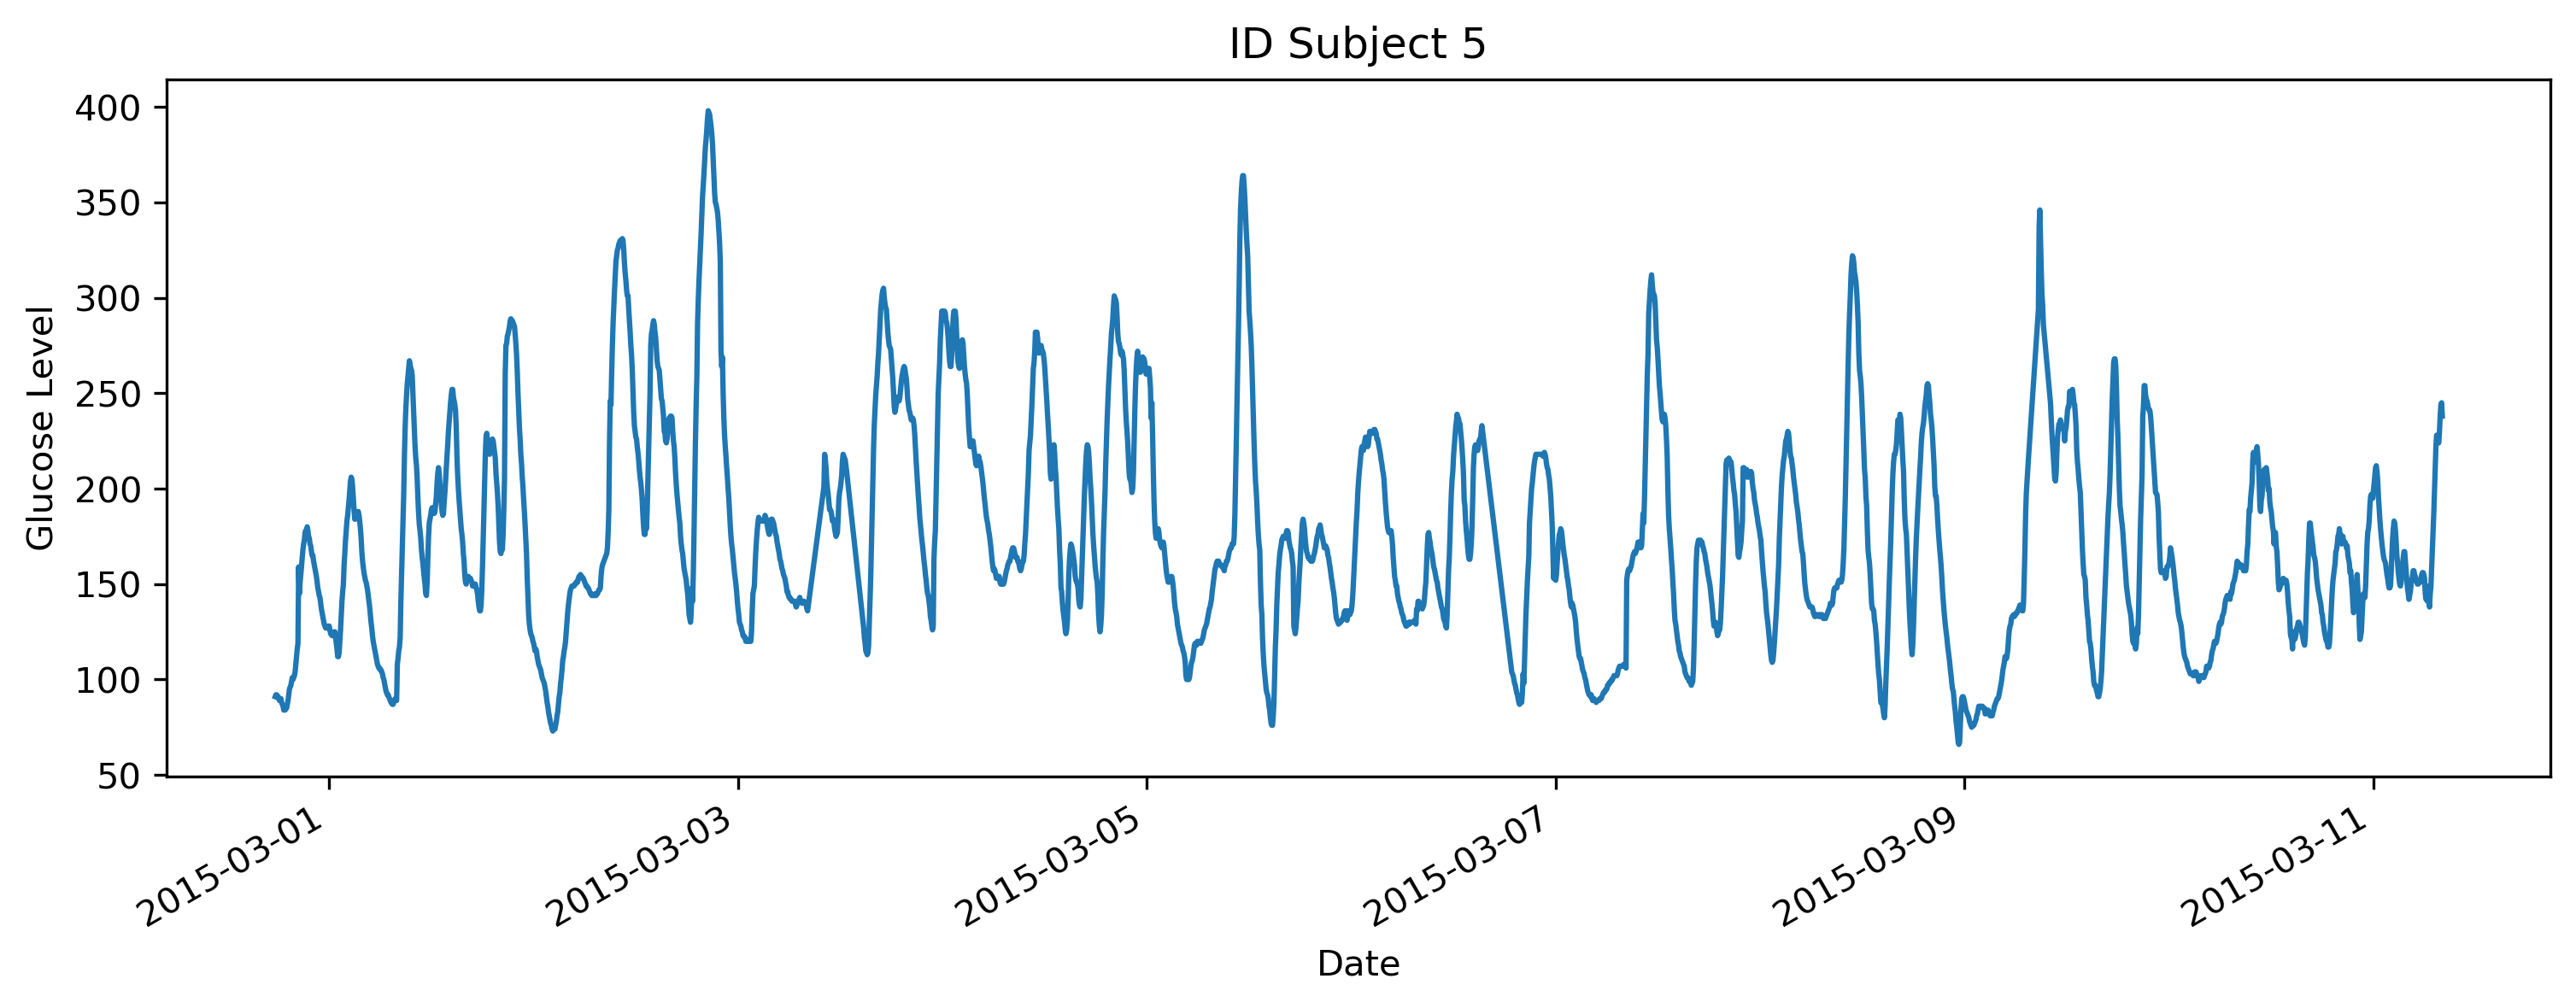

In [5]:
# Plot by ID
for ID in IDs:
    x = subj_data[ID].time # Time for x-axis
    y = subj_data[ID].gl # Glucose for y-axis

    fig, ax = plt.subplots(figsize = (12,4), dpi = 300)
    ax.plot(x, y)
    plt.title("ID " + ID)
    plt.xlabel("Date")
    plt.ylabel("Glucose Level")
    
    fig.autofmt_xdate() # slant x-axis
    plt.show()

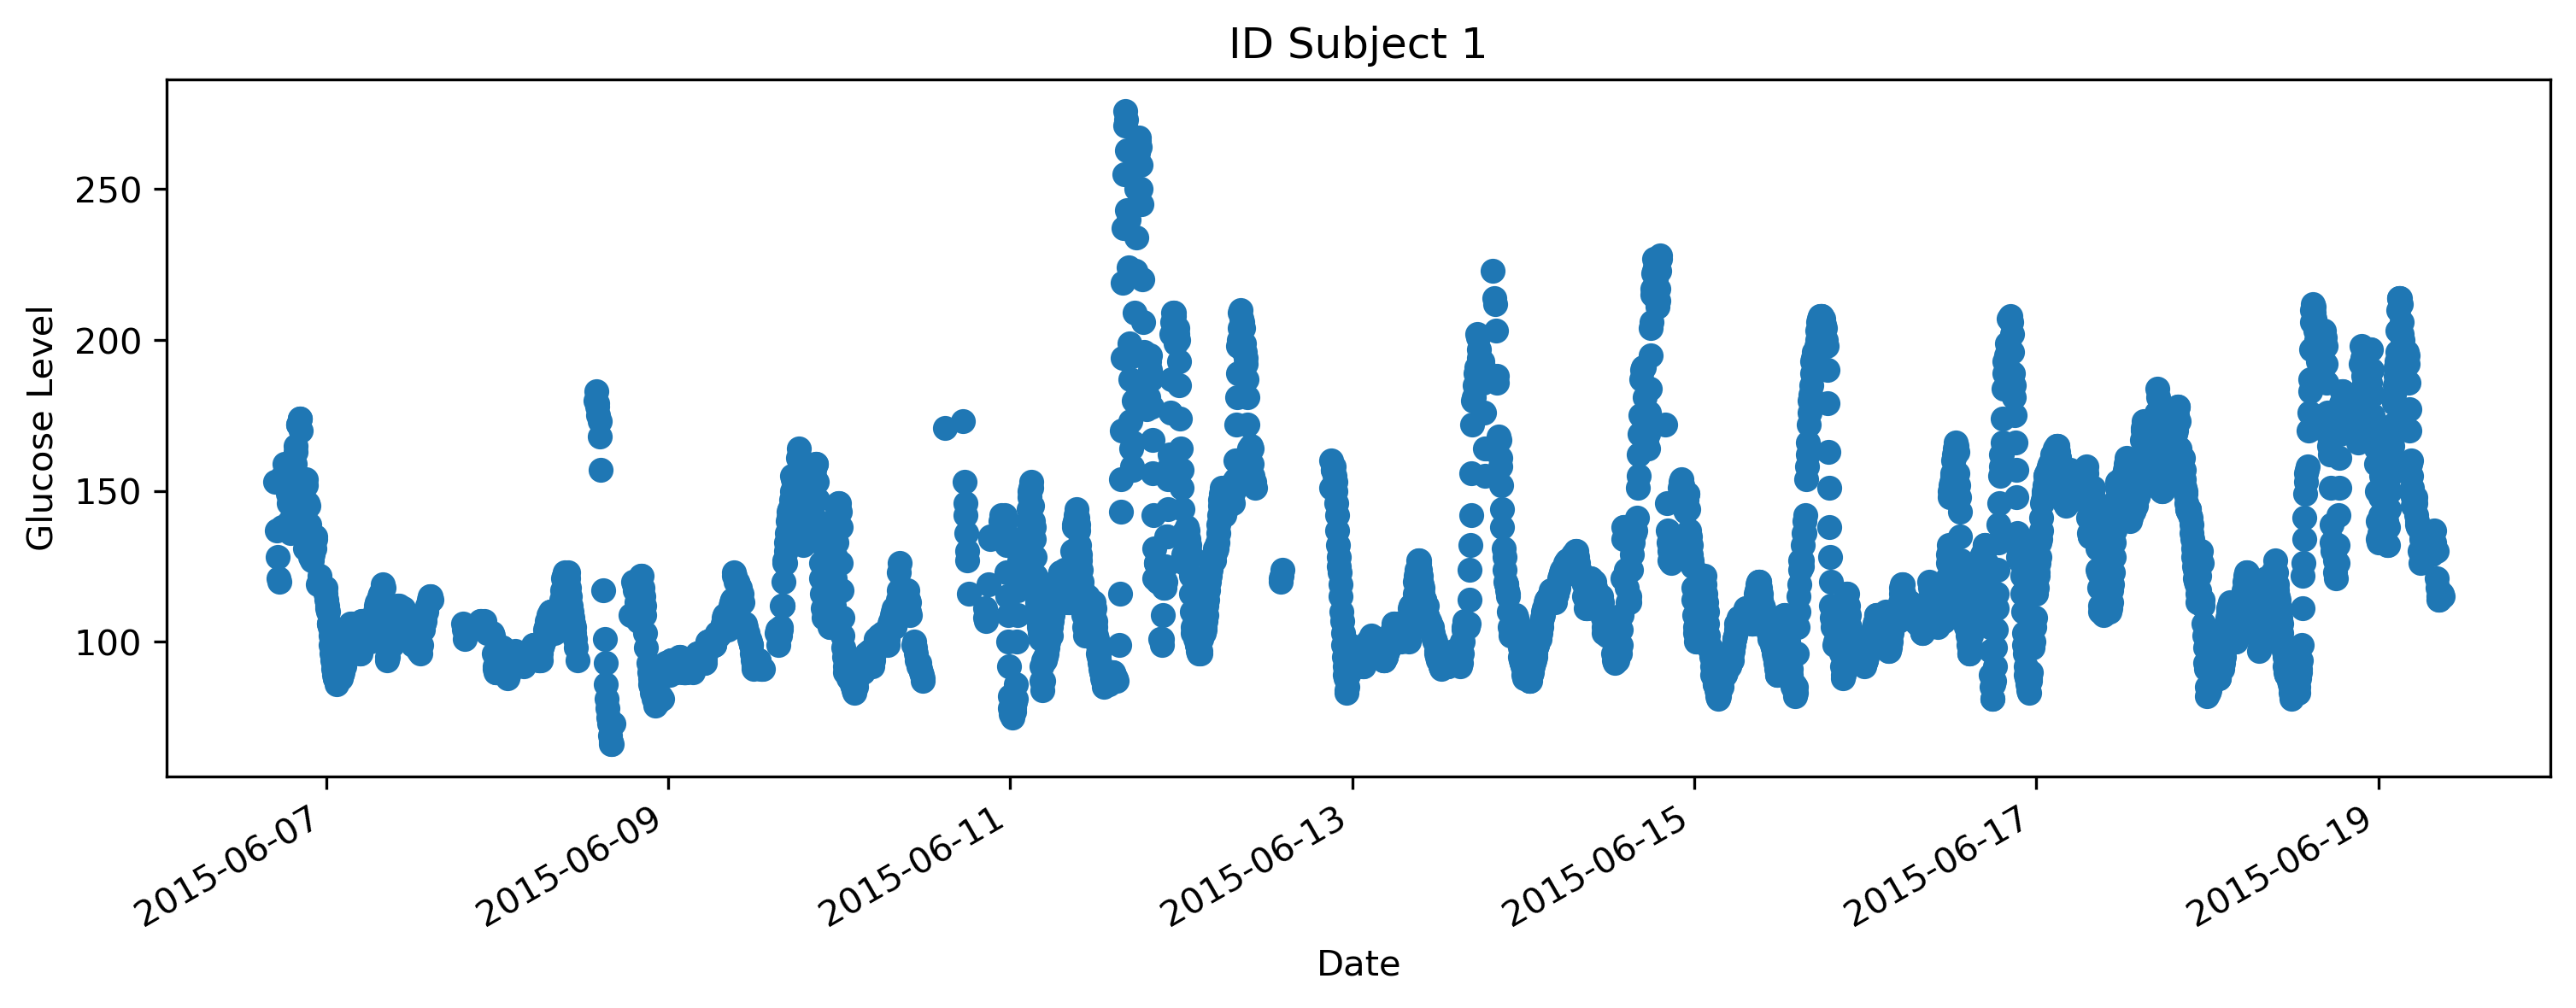

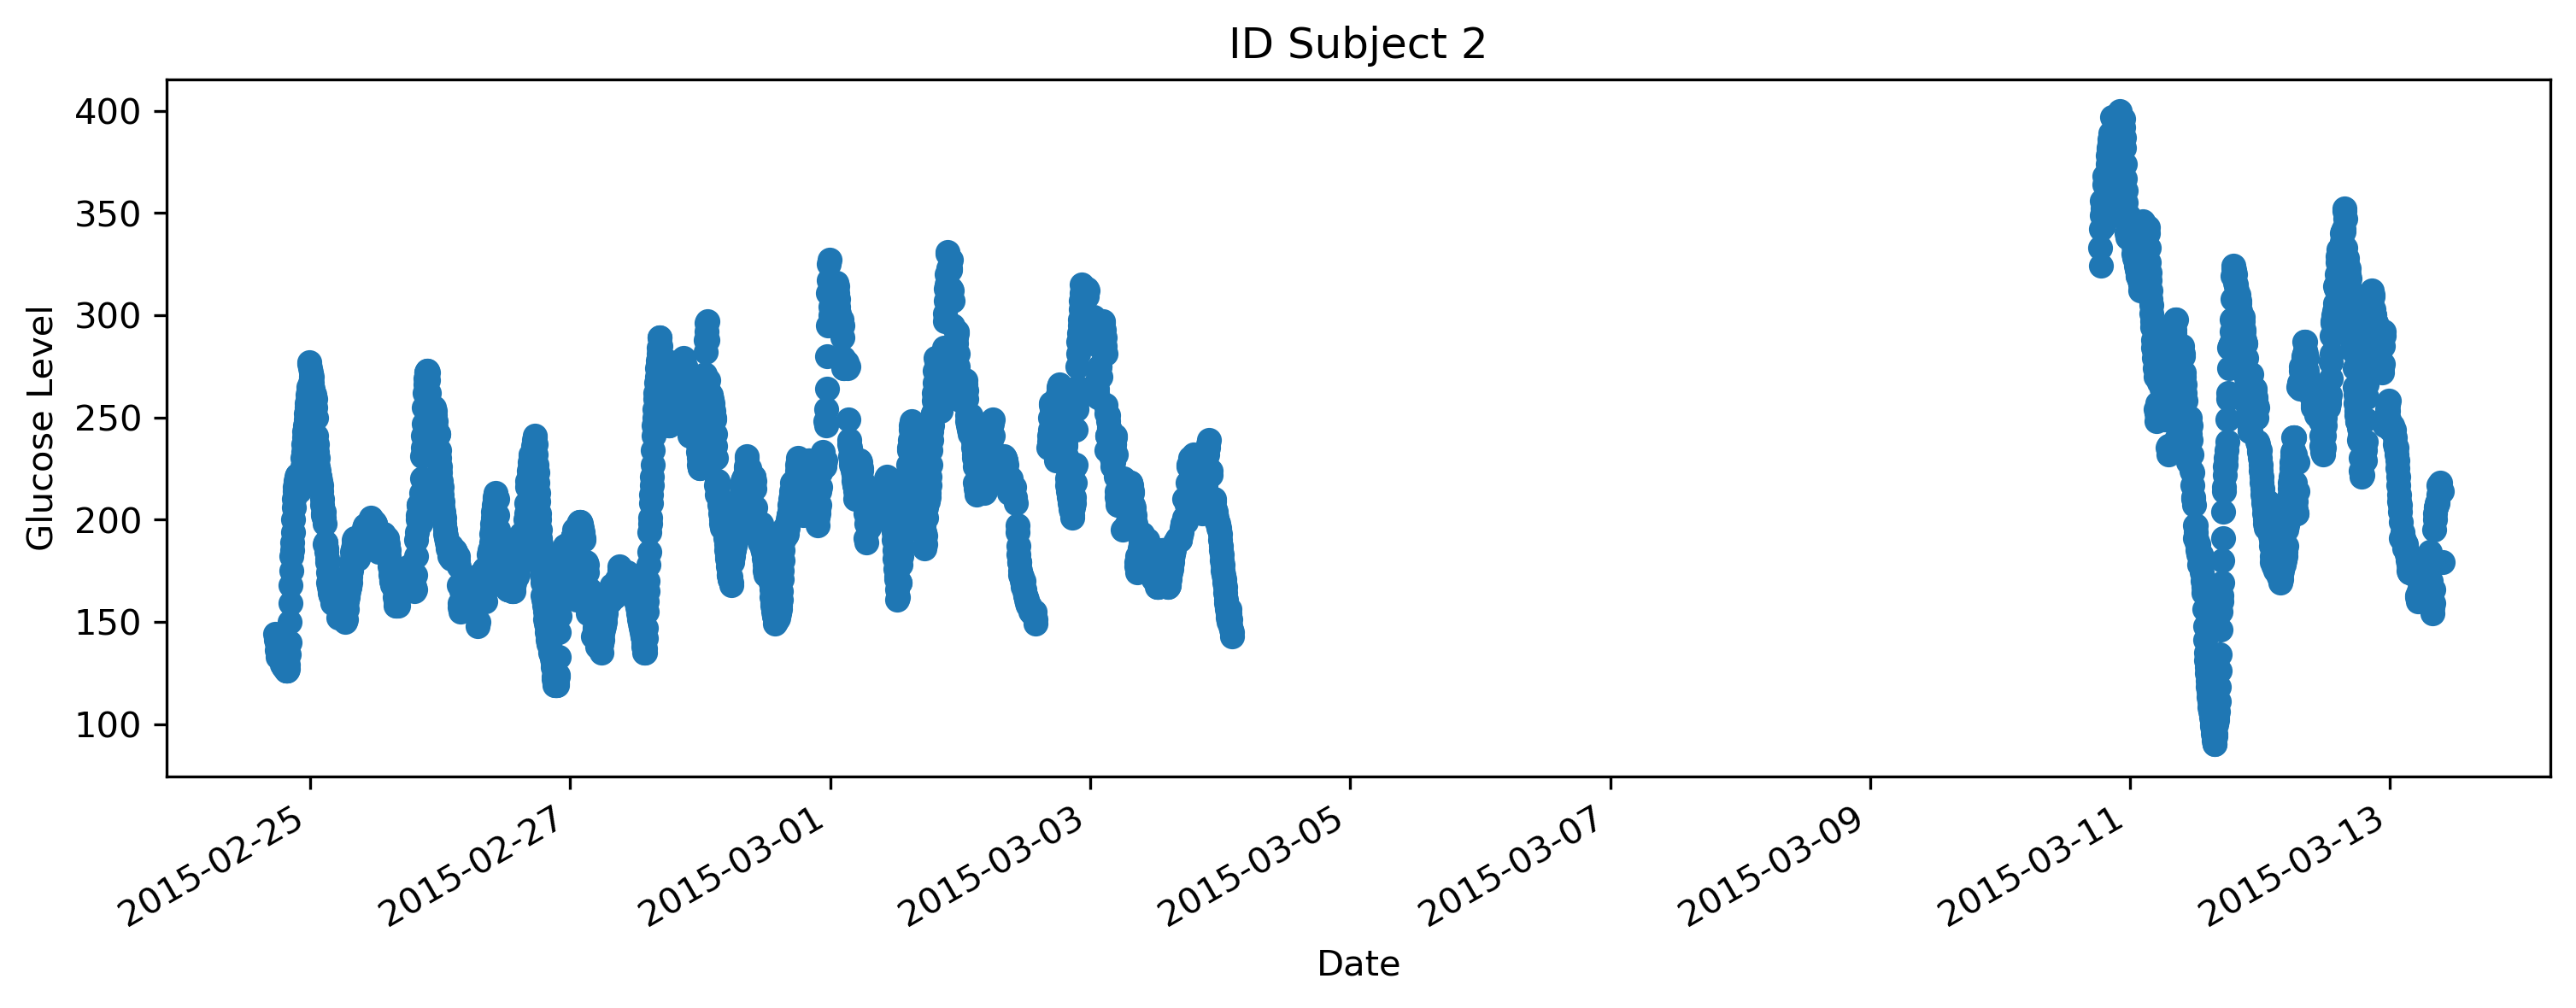

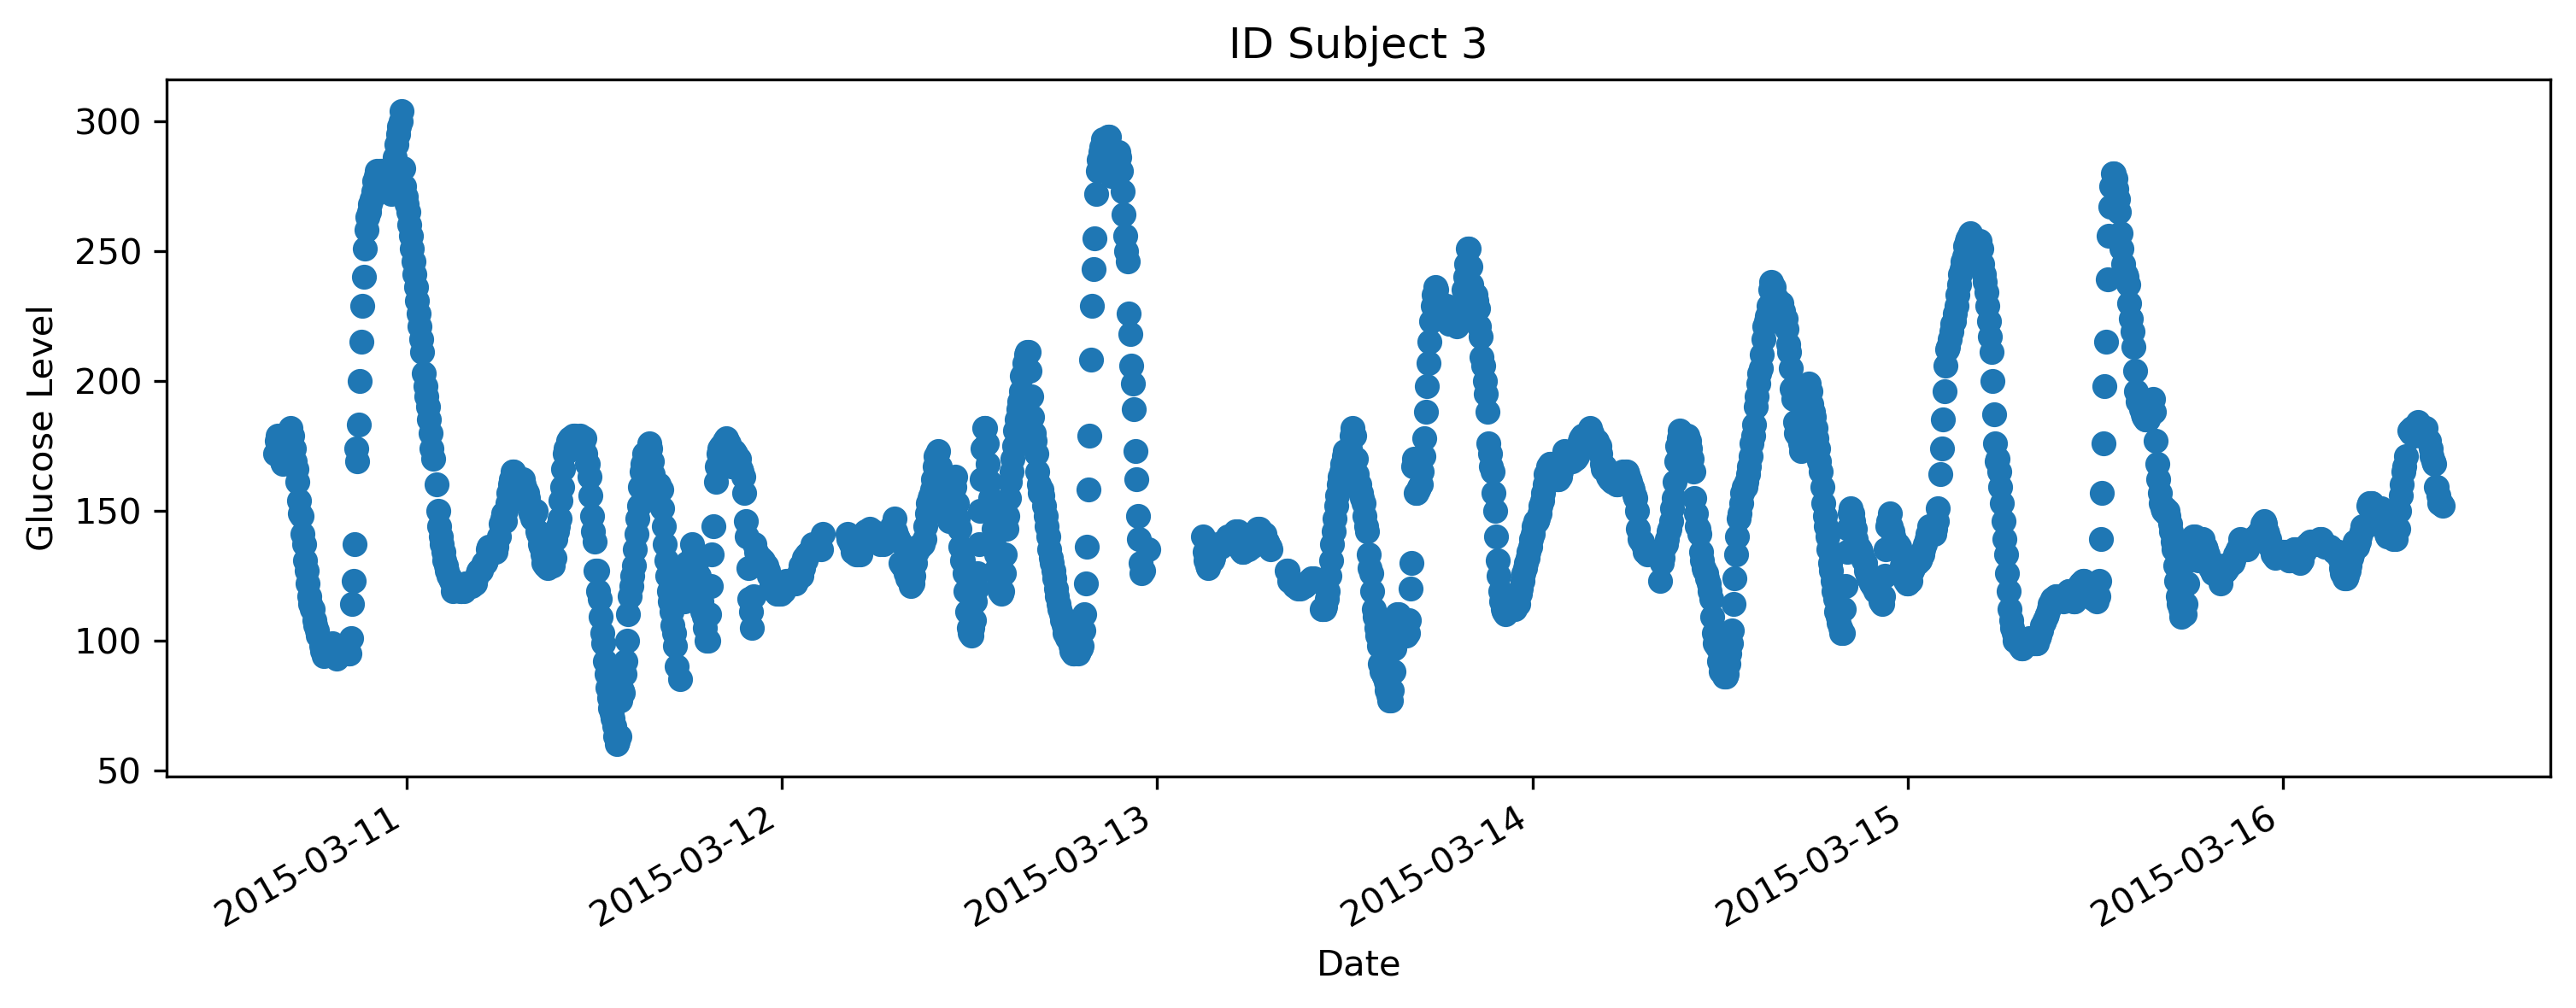

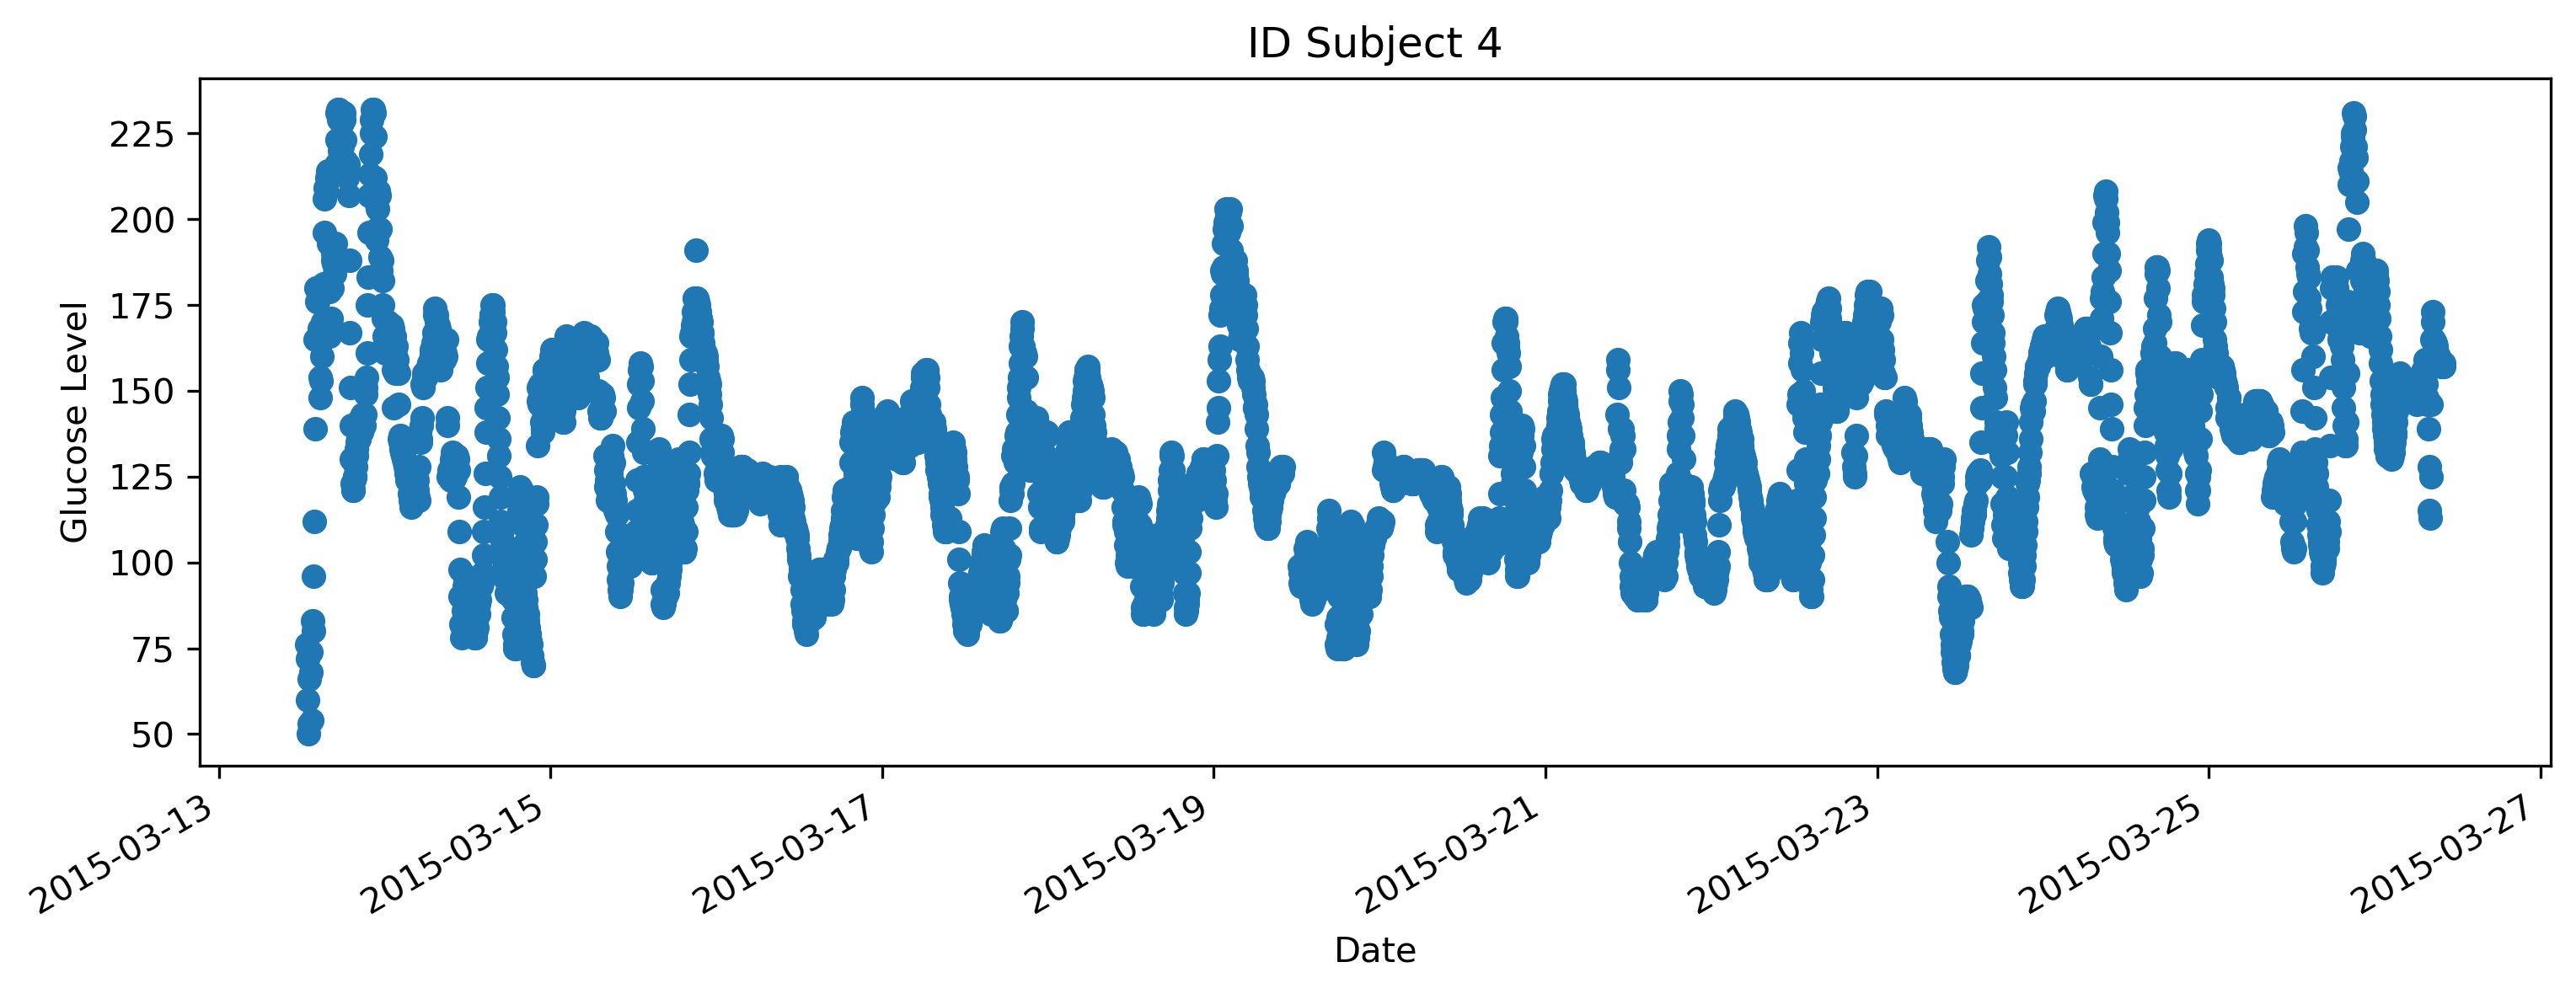

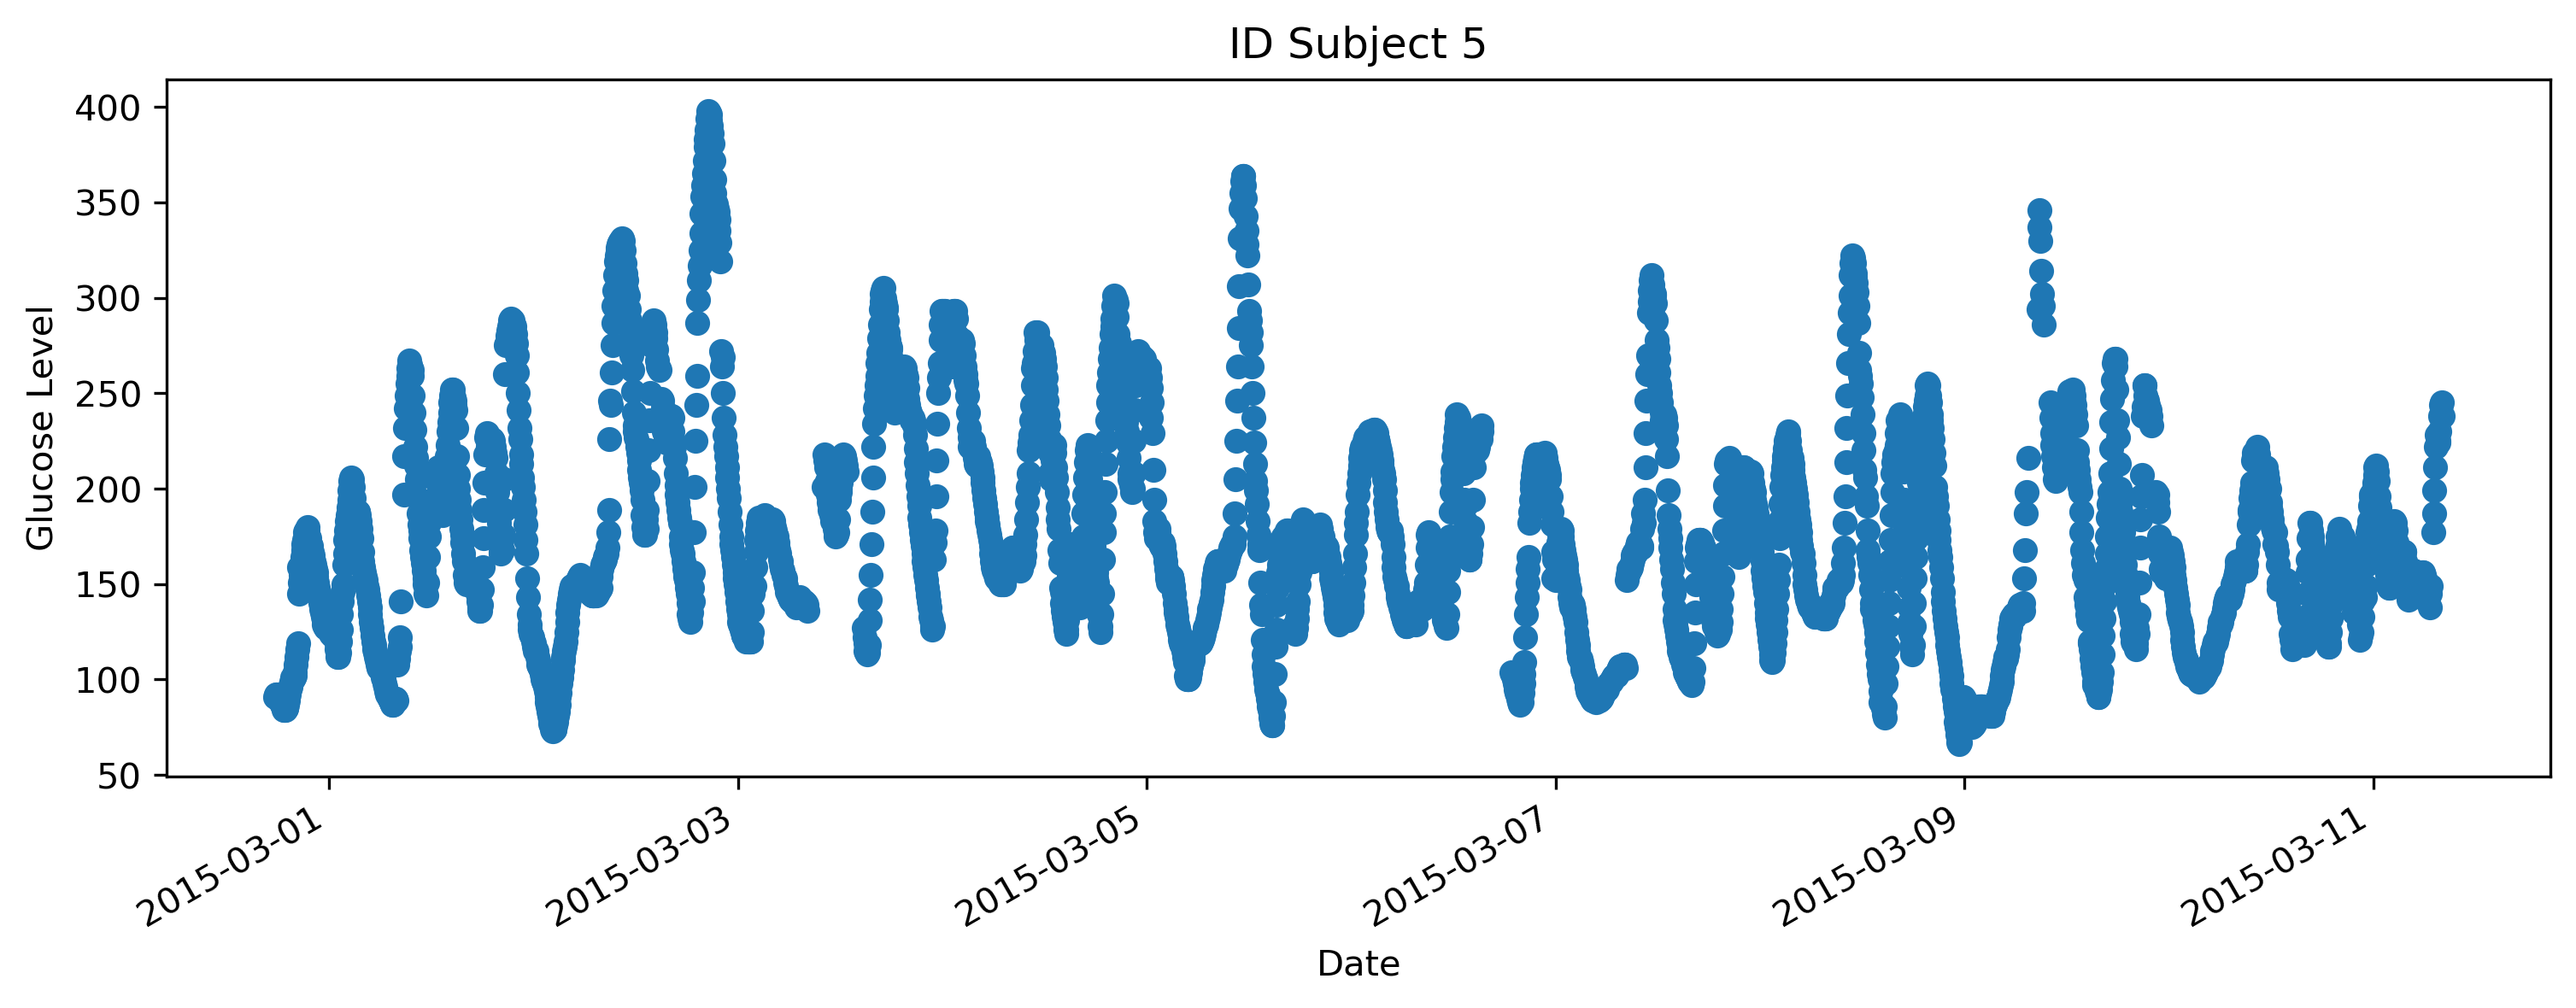

In [8]:
# Plot by ID
for ID in IDs:
    x = subj_data[ID].time # Time for x-axis (M-D-H)
    y = subj_data[ID].gl # Glucose for y-axis

    fig, ax = plt.subplots(figsize = (12,4), dpi = 300)
    ax.plot_date(x, y)
    plt.title("ID " + ID)
    plt.xlabel("Date")
    plt.ylabel("Glucose Level")
    
    fig.autofmt_xdate() # slant x-axis
    plt.show()

Data formatter example follow through

In [1]:
import data_formatters.utils as utils
from dataset import TSDataset
from conf import Conf

In [2]:
cnf = Conf(conf_file_path='./conf/iglu.yaml', seed=15, exp_name="iglu", log=False)


In [3]:
print(f'\nDefault configuration parameters: \n{cnf}')


Default configuration parameters: 
LR: 0.001
EPOCHS: 20
N_WORKERS: 0
BATCH_SIZE: 64
QUANTILES: [0.1, 0.5, 0.9]
DS_NAME: iglu
ALL_PARAMS: {'ds_name': 'iglu', 'data_csv_path': './raw_data/iglu_example_data_5_subject.csv', 'total_time_steps': 192, 'num_encoder_steps': 168, 'max_samples': 5000, 'batch_size': 64, 'device': 'cuda', 'lr': 0.001, 'num_epochs': 20, 'n_workers': 0, 'model': 'transformer', 'loader': 'base', 'quantiles': [0.1, 0.5, 0.9], 'batch_first': True, 'early_stopping_patience': 5, 'hidden_layer_size': 160, 'stack_size': 1, 'dropout_rate': 0.1, 'max_gradient_norm': 0.01, 'num_heads': 4, 'd_model': 64, 'q': 16, 'v': 16, 'h': 4, 'N': 2, 'attention_size': 0, 'dropout': 0.1, 'pe': 'original', 'chunk_mode': 'None', 'd_input': 5, 'd_output': 3}
EXP_LOG_PATH: ./log\transformer\iglu\09/16/2022.10:24:51
DEVICE: cpu


In [4]:
data_formatter = utils.make_data_formatter(cnf.ds_name)

In [5]:
# we are going to pass our data formatter and the config file to the TSDataset class
dataset = TSDataset(cnf, data_formatter)

Getting valid sampling locations.
# available segments=12911
Extracting 5000 samples out of 12911


KeyError: 'id'